In [1]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
plt.style.use('bmh')
from numba import jit, float64
from numba.types import UniTuple
from time import time
from scipy import ndimage

from scipy.interpolate import RectBivariateSpline

from ipywidgets import FloatProgress
from IPython.display import display



#import numpy as np
#from matplotlib import pyplot as plt
#plt.style.use('bmh')
#plt.rc('text', usetex=True)
#%matplotlib inline
#from numba import jit, float64
#from numba.types import UniTuple

#from time import time


#import multiprocessing as mp

#from scipy.interpolate import RectBivariateSpline

#from ipywidgets import FloatProgress
#from IPython.display import display

#from doublegyre import velocity_field

from numerical_integrators.single_step import euler, rk2, rk3, rk4

from numerical_integrators.adaptive_step import rkdp54, rkdp87

%load_ext line_profiler

In [2]:
def grid_of_particles(Nx, Ny = None, wx = 2, wy = 1):
    if Ny == None:
        Ny = np.round(Nx*wy/wx).astype(int)
        
    dx = wx / Nx
    dy = wy / Ny
    
    x0 = (np.arange(Nx) + 1/2) * dx
    y0 = (np.arange(Ny) + 1/2) * dy
    
    y, x = np.meshgrid(y0, x0)
    
    #pos = np.empty((2, Nx*Ny))
    
    #for j in range(Ny):
    #    pos[0,j*Nx:(j+1)*Nx] = x0
    #    pos[1,j*Nx:(j+1)*Nx] = y0[j]
    
    return np.array([x,y])

@jit(nopython=True)                                                            
def doublegyre(t, x, A, e, w):                                              
    a = e * np.sin(w*t)                                                         
    b = 1 - 2*e*np.sin(w*t)                                                     
    f = a*x[0,:]**2 + b*x[0,:]                                                  
    v = np.empty(x.shape)                                                   
    v[0,:] = -np.pi*A*np.sin(np.pi*f)*np.cos(np.pi*x[1,:]) # x-component        
    v[1,:] = np.pi*A*np.cos(np.pi*f)*np.sin(np.pi*x[1,:])*(2*a*x[0,:] + b) # y-component
    return v 


#@jit(nopython = True)
#def doublegyre(X, t, A, e, w):
#    a = e * np.sin(w*t)
#    b = 1 - 2*e*np.sin(w*t)
#    f = a*X[0,:]**2 + b*X[0,:]
#    v = np.empty(X.shape)
#    v[0,:] = -np.pi*A*np.sin(np.pi*f) * np.cos(np.pi*X[1,:])                    # x component of velocity
#    v[1,:] =  np.pi*A*np.cos(np.pi*f) * np.sin(np.pi*X[1,:]) * (2*a*X[0,:] + b) # y component of velocity
#    return v
    
# Function wrapper to pass to the integrator.
# x is a two-component vector, x = [x_coord, y_coord]
@jit(nopython=True)
def vel(t, x):
    # Parameters of the velocity field:
    A = 0.1         # A
    e = 0.1         # epsilon
    w = 2*np.pi/10  # omega
    return doublegyre(t,x,A,e,w)

#@jit(nopython = True)
#def f(X, t):
#    # Parameters of the velocity field
#    A = 0.1         # A
#    e = 0.1         # epsilon
#    w = 2*np.pi/10  # omega
#    return doublegyre(X, t, A, e, w)


def endpoints(t_min, t_max, pos_init, stride, integrator, deriv):
    for j in range(np.size(pos_init,0)):
        pos = pos_init[j]
        t = np.ones(np.shape(pos[0]))*t_min
        h = np.ones(np.shape(t)) * stride
        
        integration_mask = np.less(t, t_max)
        
        while np.any(integration_mask):
            h[integration_mask] = np.minimum(h[integration_mask], t_max - t[integration_mask])
            t[integration_mask], pos[:, integration_mask], h[integration_mask] = integrator(t[integration_mask], pos[:,integration_mask], h[integration_mask], deriv)
            integration_mask = np.less(t, t_max)
        
    return pos_init
            
    

def endpoints2(t_min, t_max, pos_init, stride, integrator, deriv, n_proc = 4):
    
    partition = np.floor(np.size(pos_init, 2) / n_proc).astype(int)
    
    pos = np.empty(np.shape(pos_init))
    
    queuelist = [mp.Queue() for j in range(n_proc)]
    processlist = [mp.Process(target = endpoints_slice, 
                             args = (t_min, t_max,
                                    pos_init[:, :, j*partition:np.size(pos_init, 2)if j == (n_proc - 1) else (j+1)*partition],
                                    stride, integrator, deriv, queuelist[j])) for j in range(n_proc)]
    
    for process in processlist:
        process.start()
        
    for j, queue in enumerate(queuelist):
        pos[:, :, j*partition:np.size(pos_init, 1) if j == (n_proc - 1) else (j+1) * partition] = queue.get()
        
    for process in processlist:
        process.join()
    
    return pos
    
def endpoints_slice(t_min, t_max, pos_slice, stride, integrator, deriv, q):
    for j in range(np.size(pos_slice,0)):
        
        pos = pos_slice[j]
        t = np.ones(np.shape(pos[0])) * t_min
        h = np.ones(np.shape(pos[0])) * stride
        #print(np.shape(pos_slice[j,:]))
        #print(np.shape(deriv(t, pos_slice[j])) )
    
        #pos_slice = np.copy(pos_init_slice)
        
        #print(np.shape(t))
        
    
        integration_mask = np.less(t, t_max)
        #print (np.shape(integration_mask))
        #i = 0
    
        while np.any(integration_mask):
         #   i +=1
            h[integration_mask] = np.minimum(h[integration_mask], t_max - t[integration_mask])
            #print (np.shape(pos_slice[j,:,integration_mask]))
            t[integration_mask], tmp, h[integration_mask] = integrator(t[integration_mask], pos[:,integration_mask], h[integration_mask], deriv)
            pos[:, integration_mask] = tmp
            integration_mask = np.less(t, t_max)
    #print(i)
    q.put(pos_slice)

In [3]:
# Particle count in the x-direction:
Nx = 200
# --------''----------- y-direction:
Ny = 100

# ----
#      Main grid:
# ----
pos_init = grid_of_particles(Nx, Ny)

# Grid parameters, original grid:
dx = pos_init[0,-1,0] - pos_init[0, -2,0]
dy = pos_init[1,0,-1] - pos_init[1, 0,-2]

# New transport parameters:
t_min = 0.
t_max = 20.
h = 0.01


# ----
#     Auxiliary grid:
# ----

# Grid spacing: Must be smaller than original grid
d = np.minimum(1e-5, dx * 1e-2)


# ----
#      Integration:
# ----

# Integrator choice:
integrator = rk4

# Trajectory endpoints:

#tic = time()

#pos_fin = endpoints(t_min, t_max, np.array([pos_init, pos_init + np.array([d,0]).reshape(2,1,1),
#                             pos_init + np.array([0,d]).reshape(2,1,1), 
#                               pos_init + np.array([-d, 0]).reshape(2,1,1),
#                               pos_init + np.array([0,-d]).reshape(2,1,1)]), h, integrator, vel)

#pos_fin = endpoints_fixed(t_min, t_max, pos_init, h, integrator, vel)


#above_fin = endpoints_fixed(t_min, t_max, pos_init + np.array([0,d]).reshape(2,1,1), h, integrator, vel)
#beneath_fin = endpoints_fixed(t_min, t_max, pos_init + np.array([0,-d]).reshape(2,1,1), h, integrator, vel)

#right_fin = endpoints_fixed(t_min, t_max, pos_init + np.array([d,0]).reshape(2,1,1), h, integrator, vel)
#left_fin = endpoints_fixed(t_min, t_max, pos_init + np.array([-d,0]).reshape(2,1,1), h, integrator, vel)

#toc = time()

#print('Transport took %.3f seconds' % (toc - tic))

In [4]:
%lprun -f integrator endpoints(t_min, t_max, np.array([pos_init, pos_init + np.array([d,0]).reshape(2,1,1),pos_init + np.array([0,d]).reshape(2,1,1), pos_init + np.array([-d, 0]).reshape(2,1,1), pos_init + np.array([0,-d]).reshape(2,1,1)]), h, integrator, vel)

In [13]:
pos_slice = np.array([pos_init, pos_init, pos_init, pos_init, pos_init])
np.shape(pos_slice)

(5, 2, 200, 100)

205 s, 99 % integrator

In [23]:
pos_init= grid_of_particles(Nx = 20, Ny = 10)

integrator = rk4

h = 0.1
t_min = 0
t_max = 20

pos_fin = endpoints(t_min, t_max, pos_init, stride = h, integrator = integrator, deriv = vel)

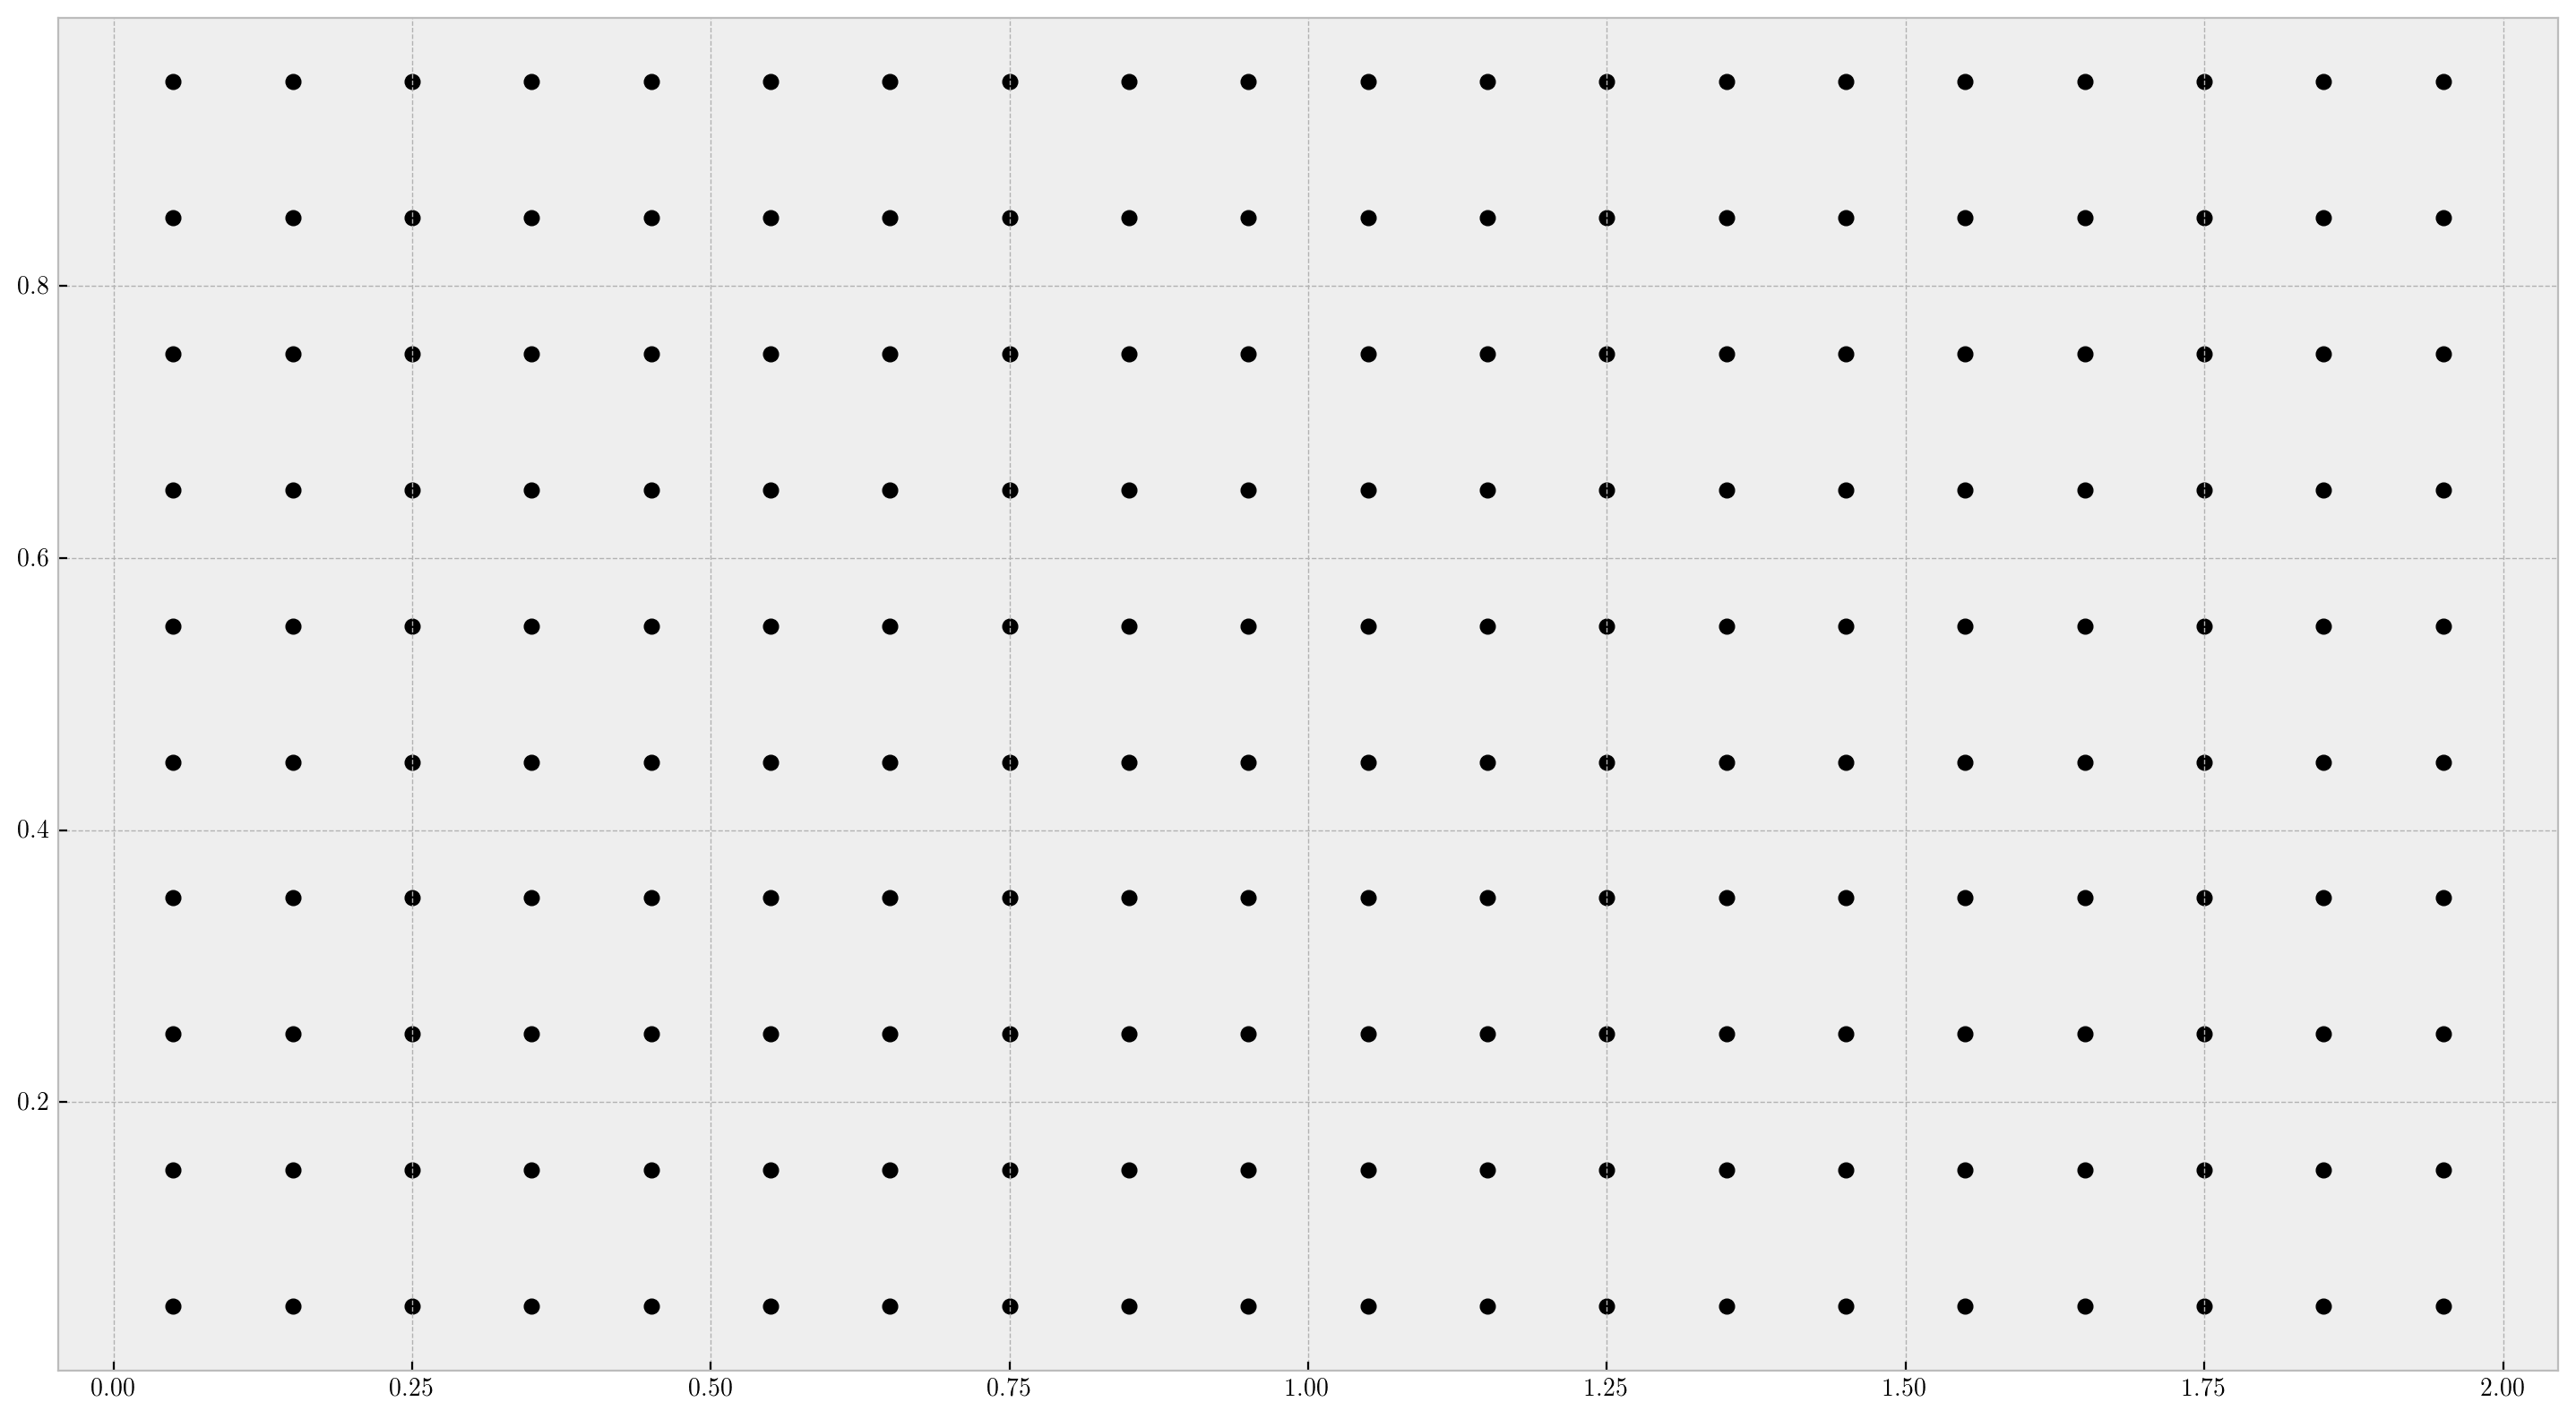

In [14]:
plt.figure(figsize = (18,10), dpi = 200)
plt.scatter(pos_init[0], pos_init[1],  color = 'k')

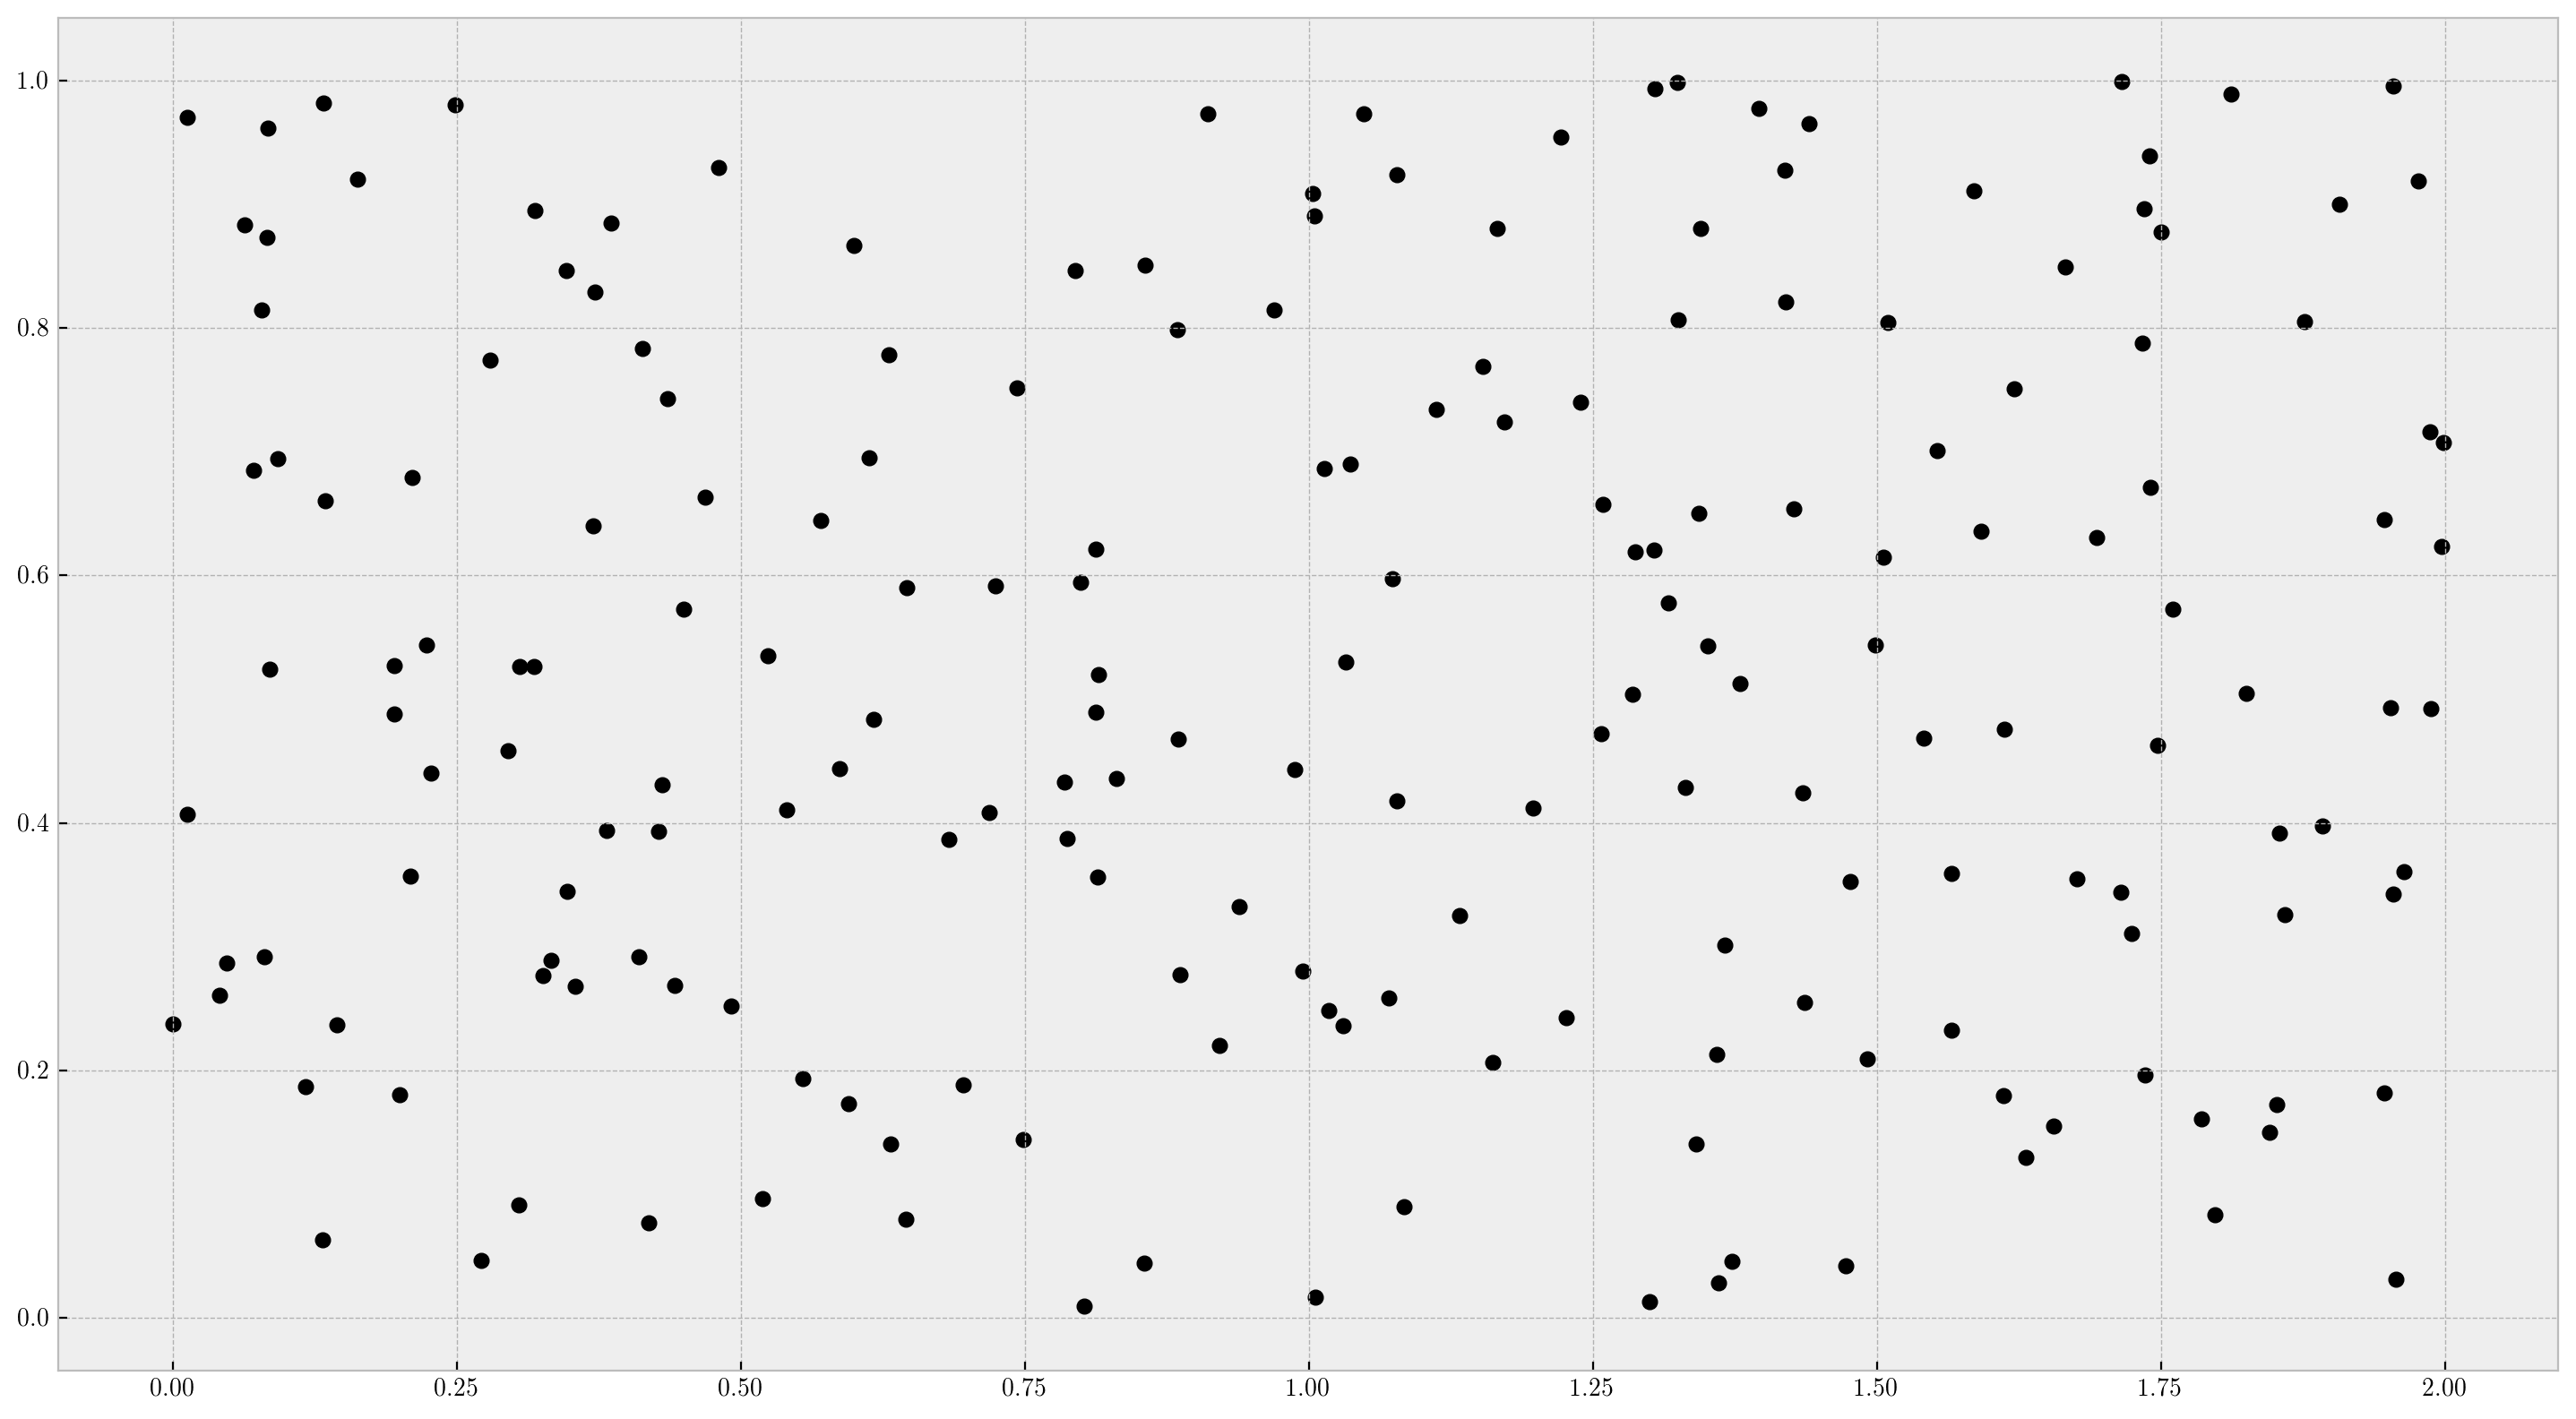

In [16]:
plt.figure(figsize = (18, 10), dpi = 200)
plt.scatter(pos_fin[0], pos_fin[1], color = 'k')

In [22]:
print(pos_init[1,:,:].T)
print(pos_fin[1, :, :].T)

[[ 0.05  0.05  0.05  0.05  0.05  0.05  0.05  0.05  0.05  0.05  0.05  0.05
   0.05  0.05  0.05  0.05  0.05  0.05  0.05  0.05]
 [ 0.15  0.15  0.15  0.15  0.15  0.15  0.15  0.15  0.15  0.15  0.15  0.15
   0.15  0.15  0.15  0.15  0.15  0.15  0.15  0.15]
 [ 0.25  0.25  0.25  0.25  0.25  0.25  0.25  0.25  0.25  0.25  0.25  0.25
   0.25  0.25  0.25  0.25  0.25  0.25  0.25  0.25]
 [ 0.35  0.35  0.35  0.35  0.35  0.35  0.35  0.35  0.35  0.35  0.35  0.35
   0.35  0.35  0.35  0.35  0.35  0.35  0.35  0.35]
 [ 0.45  0.45  0.45  0.45  0.45  0.45  0.45  0.45  0.45  0.45  0.45  0.45
   0.45  0.45  0.45  0.45  0.45  0.45  0.45  0.45]
 [ 0.55  0.55  0.55  0.55  0.55  0.55  0.55  0.55  0.55  0.55  0.55  0.55
   0.55  0.55  0.55  0.55  0.55  0.55  0.55  0.55]
 [ 0.65  0.65  0.65  0.65  0.65  0.65  0.65  0.65  0.65  0.65  0.65  0.65
   0.65  0.65  0.65  0.65  0.65  0.65  0.65  0.65]
 [ 0.75  0.75  0.75  0.75  0.75  0.75  0.75  0.75  0.75  0.75  0.75  0.75
   0.75  0.75  0.75  0.75  0.75  0.75  0.75  0.75]


# Step 0: Check that the transport goes as planned

In [5]:
Nx = 400
pos_init = grid_of_particles(Nx)

integrator = rk4

# Transport parameters:
t_min = 0
t_max = 5
h = 0.1

# Loop over grid and update all positions:
tic = time()
pos_fin = endpoints_fixed(t_min, t_max, pos_init, h, integrator, vel)
toc = time()

print('Transport took %.3f seconds' % (toc - tic))

Transport took 9.063 seconds


(0, 1)

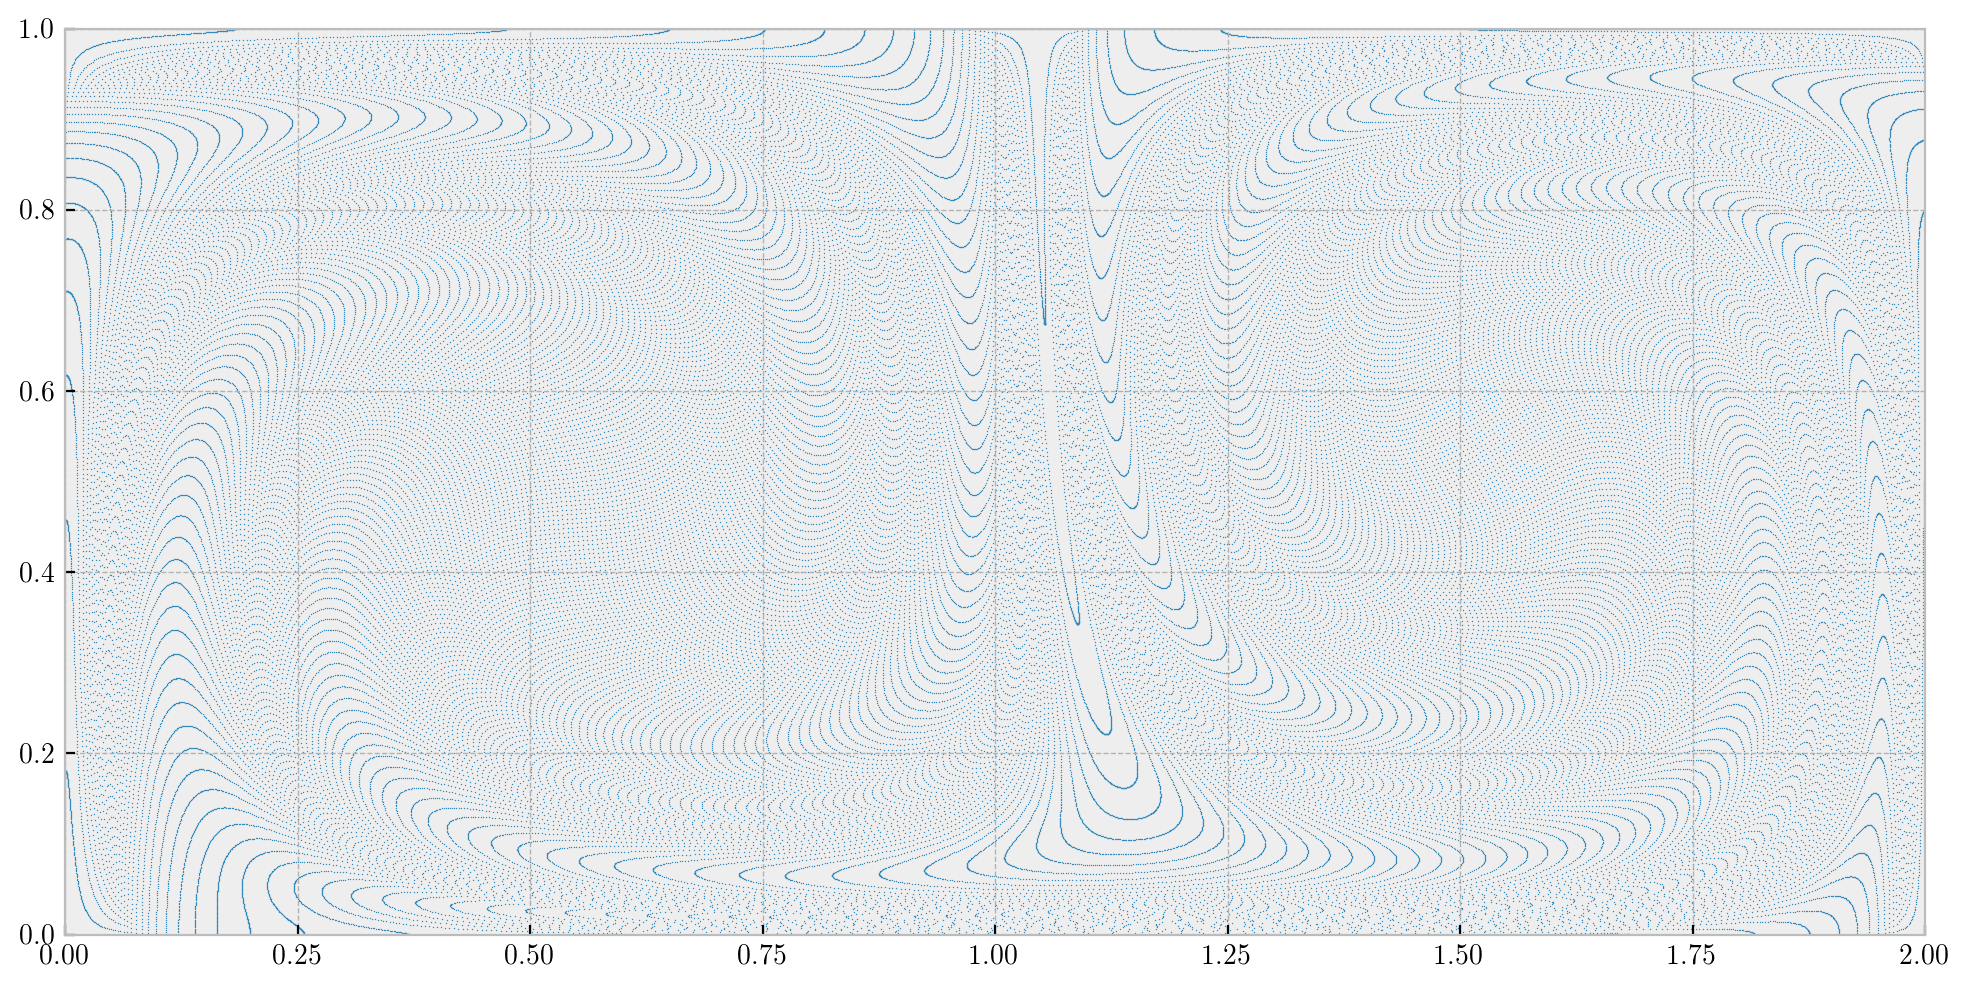

In [4]:
# Make a scatter plot to show grid points:
fig = plt.figure(figsize = (12,6), dpi = 200)
plt.scatter(pos_fin[0,:], pos_fin[1,:], lw = 0, marker = '.', s = 1)
plt.xlim(0, 2)
plt.ylim(0, 1)

# Step 1: Calculate flow map for lots of particles

### In addition, calculate flow map for four auxiliary grid points per particle

In [26]:
# Particle count in the x-direction:
Nx = 200
# --------''----------- y-direction:
Ny = 100

# ----
#      Main grid:
# ----
pos_init = grid_of_particles(Nx, Ny)

# Grid parameters, original grid:
dx = pos_init[0,-1,0] - pos_init[0, -2,0]
dy = pos_init[1,0,-1] - pos_init[1, 0,-2]

# New transport parameters:
t_min = 0.
t_max = 20.
h = 0.01


# ----
#     Auxiliary grid:
# ----

# Grid spacing: Must be smaller than original grid
d = np.minimum(1e-5, dx * 1e-2)


# ----
#      Integration:
# ----

# Integrator choice:
integrator = rk4

# Trajectory endpoints:

tic = time()

pos_fin = endpoints_fixed(t_min, t_max, pos_init, h, integrator, vel)


above_fin = endpoints_fixed(t_min, t_max, pos_init + np.array([0,d]).reshape(2,1,1), h, integrator, vel)
beneath_fin = endpoints_fixed(t_min, t_max, pos_init + np.array([0,-d]).reshape(2,1,1), h, integrator, vel)

right_fin = endpoints_fixed(t_min, t_max, pos_init + np.array([d,0]).reshape(2,1,1), h, integrator, vel)
left_fin = endpoints_fixed(t_min, t_max, pos_init + np.array([-d,0]).reshape(2,1,1), h, integrator, vel)

toc = time()

print('Transport took %.3f seconds' % (toc - tic))


Transport took 152.343 seconds


In [27]:
print(np.shape(np.array([pos_fin, above_fin, beneath_fin, right_fin, left_fin])))

(5, 2, 200, 100)


# Step 2: Calculate derivatives of flow maps

In [32]:
# [0,0]-component: dx/dx
# [0,1]-component: dx/dy
# [1,0]-component: dy/dx
# [1,1]-component: dy/dy

dF = np.empty((2, 2, Nx, Ny))
dF_a = np.copy(dF)

# Derivatives for auxiliary array:
# Centered differencing throughout
# dx/dx
dF_a[0,0,:,:] = (right_fin[0] - left_fin[0]) / (2*d)
# dx/dy
dF_a[0,1,:,:] = (above_fin[0] - beneath_fin[0]) / (2*d)
# dy/dx
dF_a[1,0,:,:] = (right_fin[1] - left_fin[1]) / (2*d)
# dy/dy
dF_a[1,1,:,:] = (above_fin[1] - beneath_fin[1]) / (2*d)

# Derivatives for main array:

# dx/dx
dF[0,0,0,:]    = (-3*pos_fin[0,0,:] + 4*pos_fin[0,1,:] - 2*pos_fin[0,2,:]) / (2*dx)   # 2nd order accurate forward differencing
dF[0,0,1:-2,:] = (pos_fin[0,2:-1,:] - pos_fin[0,0:-3,:]) / (2*dx)                     # Centered differencing
dF[0,0,-1,:]   = (3*pos_fin[0,-1,:] - 4*pos_fin[0,-2,:] + 2*pos_fin[0,-3,:]) / (2*dx) # 2nd order accurate backward differencing

# dx/dy
dF[0,1,:,0]    = (-3*pos_fin[0,:,0] + 4*pos_fin[0,:,1] - 2*pos_fin[0,:,2]) / (2*dy)   # 2nd order accurate forward differencing
dF[0,1,:,1:-2] = (pos_fin[0,:,2:-1] - pos_fin[0,:,0:-3]) / (2*dy)                     # Centered differencing
dF[0,1,:,-1]   = (3*pos_fin[0,:,-1] - 4*pos_fin[0,:,-2] + 2*pos_fin[0,:,-3]) / (2*dy) # 2nd order accurate backward differencing

# dy/dx
dF[1,0,0,:]    = (-3*pos_fin[1,0,:] + 4*pos_fin[1,1,:] - 2*pos_fin[1,2,:]) / (2*dx)   # 2nd order accurate forward differencing
dF[1,0,1:-2,:] = (pos_fin[1,2:-1,:] - pos_fin[1,0:-3,:]) / (2*dx)                     # Centered differencing
dF[1,0,-1,:]   = (3*pos_fin[1,-1,:] - 4*pos_fin[1,-2,:] + 2*pos_fin[1,-3,:]) / (2*dx) # 2nd order accurate backward differencing

# dy/dy
dF[1,1,:,0]    = (-3*pos_fin[1,:,0] + 4*pos_fin[1,:,1] - 2*pos_fin[1,:,2]) / (2*dy)   # 2nd order accurate forward differencing
dF[1,1,:,1:-2] = (pos_fin[1,:,2:-1] - pos_fin[1,:,0:-3]) / (2*dy)                     # Centered differencing
dF[1,1,:,-1]   = (3*pos_fin[1,:,-1] - 4*pos_fin[1,:,-2] + 2*pos_fin[1,:,-3]) / (2*dy) # 2nd order accurate backward differencing


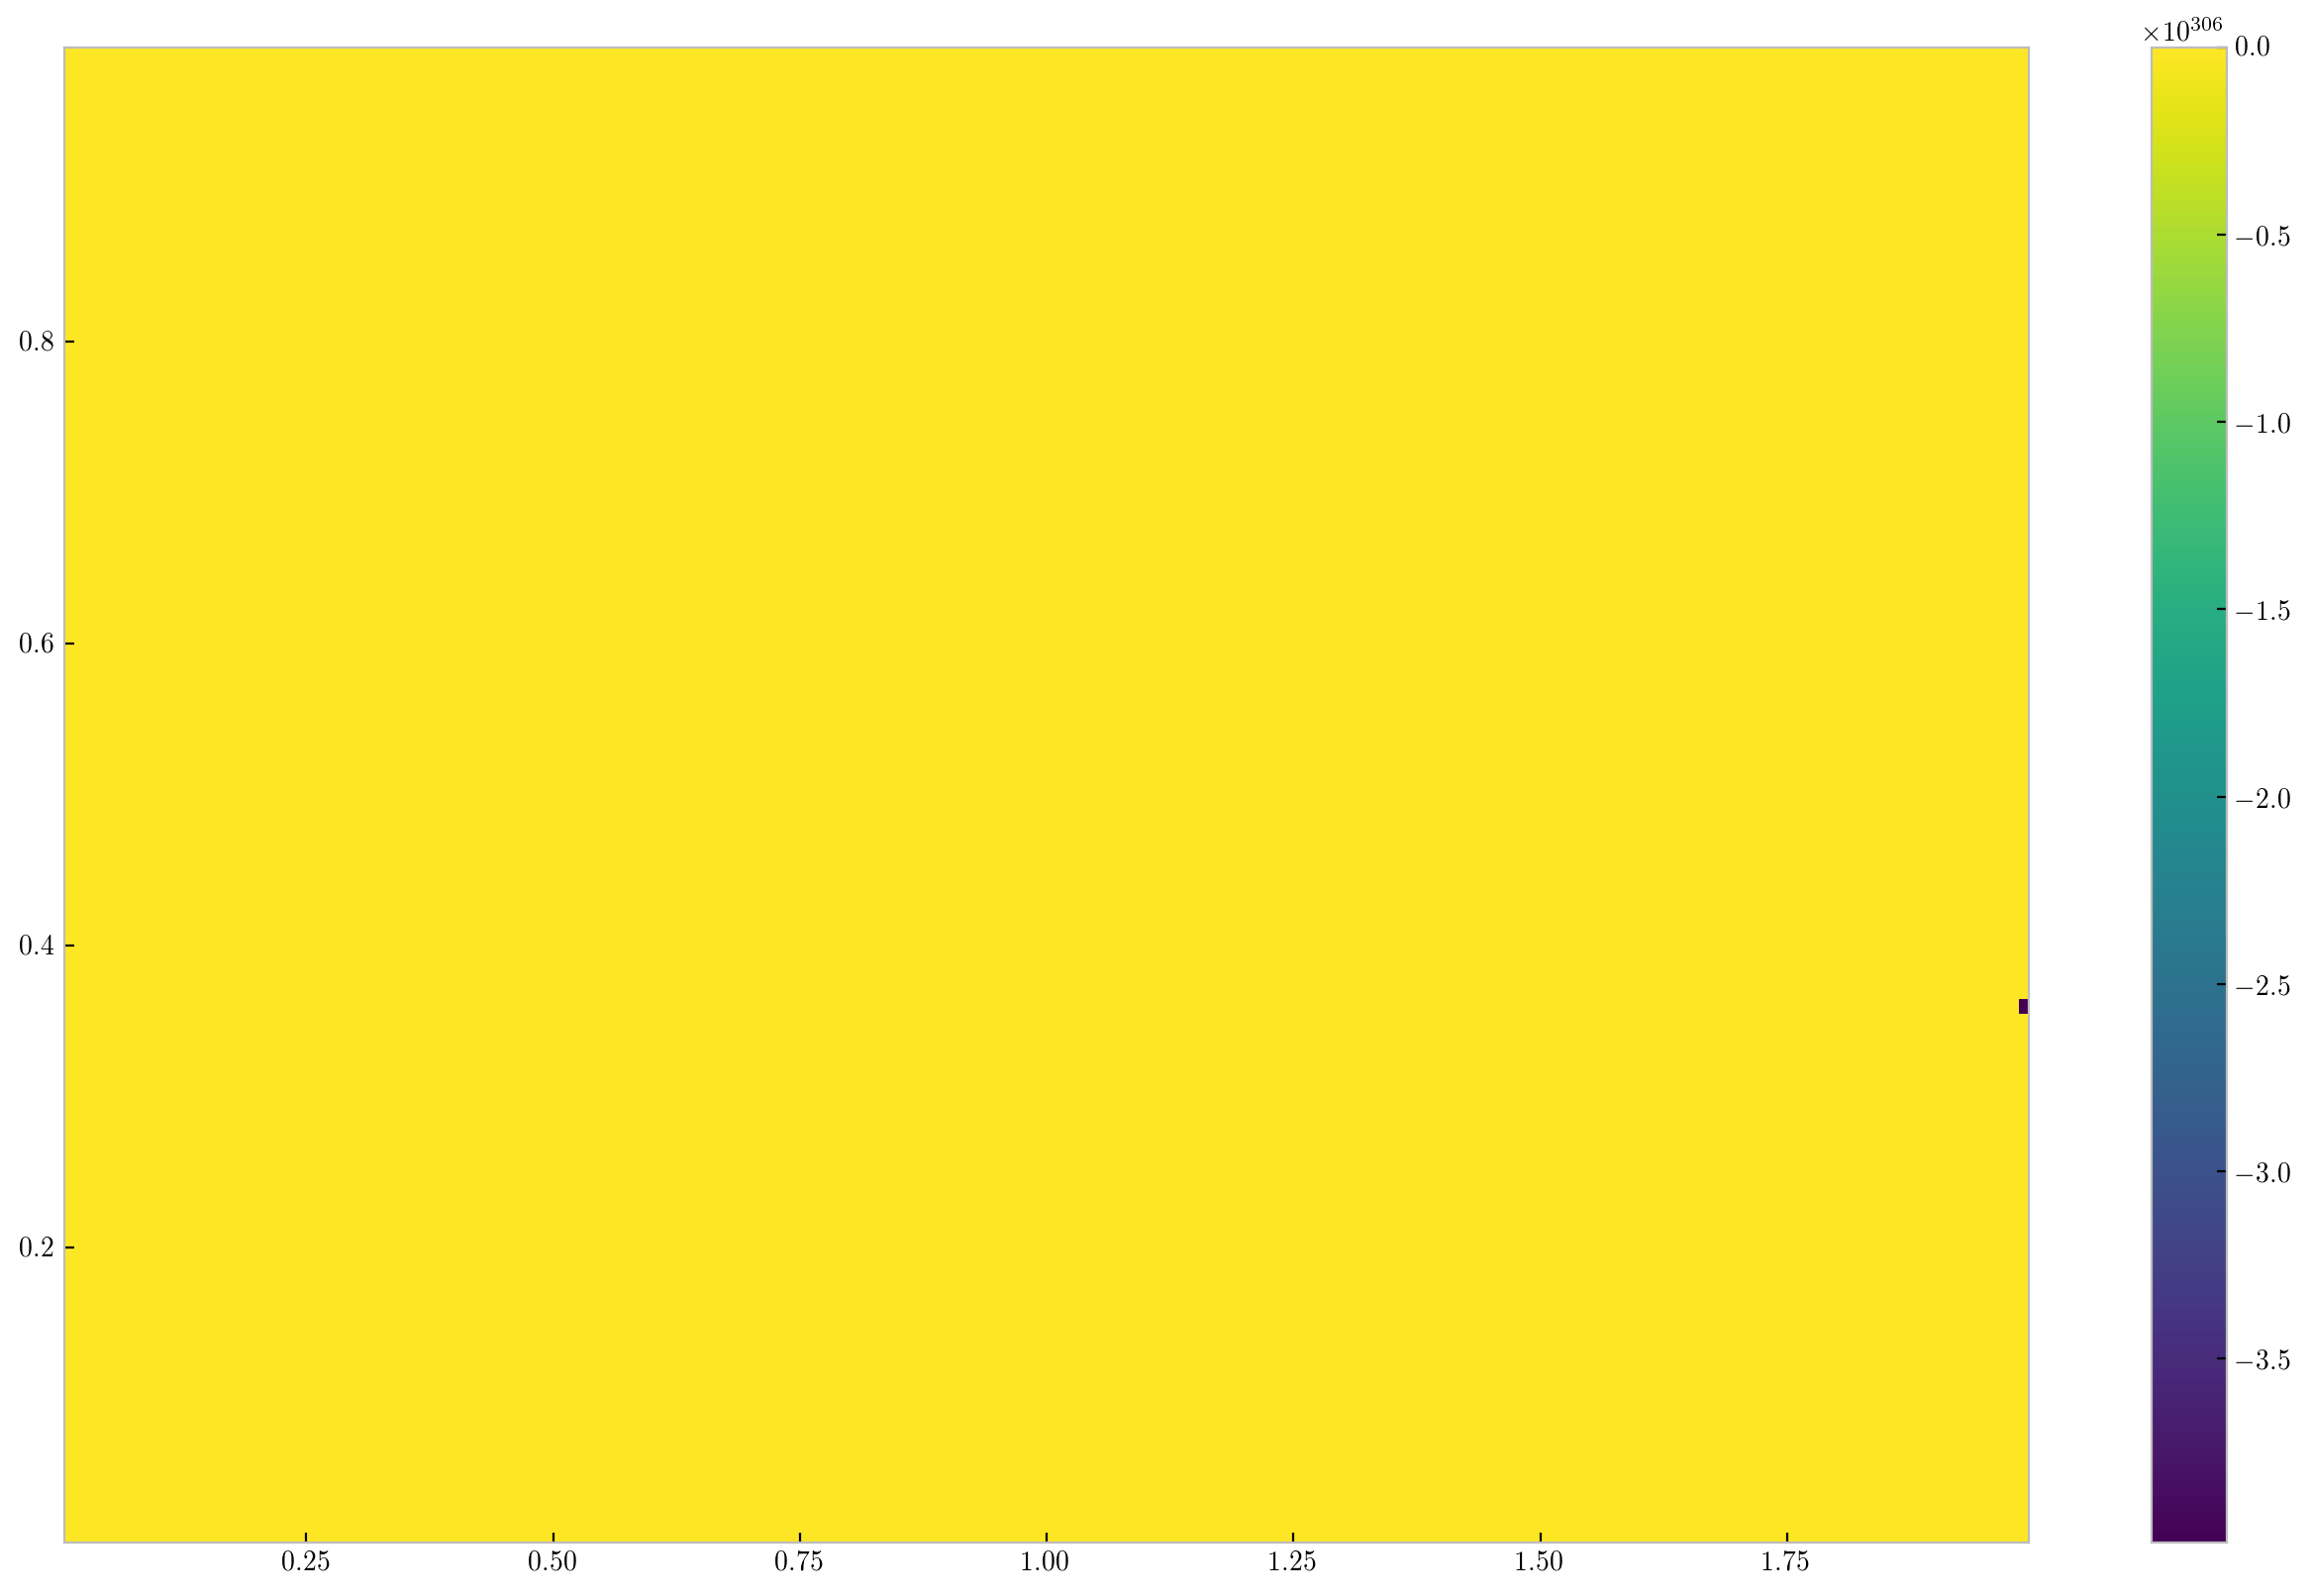

In [6]:
plt.figure(figsize = (16,10), dpi = 200)
mesh = plt.pcolormesh(pos_init[0,:,:], pos_init[1,:,:], dF[0,0,:,:])
plt.colorbar(mesh)


# Step 3: Calculate Cauchy-Green strain tensor

In [33]:
C = np.empty(dF.shape)
C_a = np.empty(dF_a.shape)

assert dF.shape == dF_a.shape

for i in range(dF_a.shape[2]):
    for j in range(dF_a.shape[3]):
        C[:,:,i,j] = np.dot(dF[:,:,i,j].T, dF[:,:,i,j])
        C_a[:,:,i,j] = np.dot(dF_a[:,:,i,j].T, dF_a[:,:,i,j])

# Step 4: Calculate eigenvalues and -vectors of Cauchy-Green strain tensors

In [34]:
evals = np.empty((2, dF_a.shape[2], dF_a.shape[3]))
evecs = np.empty(C.shape)

evals_discard = np.copy(evals)
evecs_discard = np.copy(evecs)

for i in range(dF_a.shape[2]):
    for j in range(dF_a.shape[3]):
        vals, vecs = np.linalg.eigh(C[:,:,i,j])
        vals_a, vecs_a = np.linalg.eigh(C_a[:,:,i,j])
        
        idxvals = vals.argsort()[::-1]
        idxvals_a = vals_a.argsort()[::-1]
        
        evals[:,i,j] = vals[idxvals]
        evecs_discard[:,:,i,j] = vecs[:, idxvals]
        
        evals_discard[:,i,j] = vals_a[idxvals_a] 
        evecs[:,:,i,j] = vecs_a[:,idxvals_a]

(0, 1)

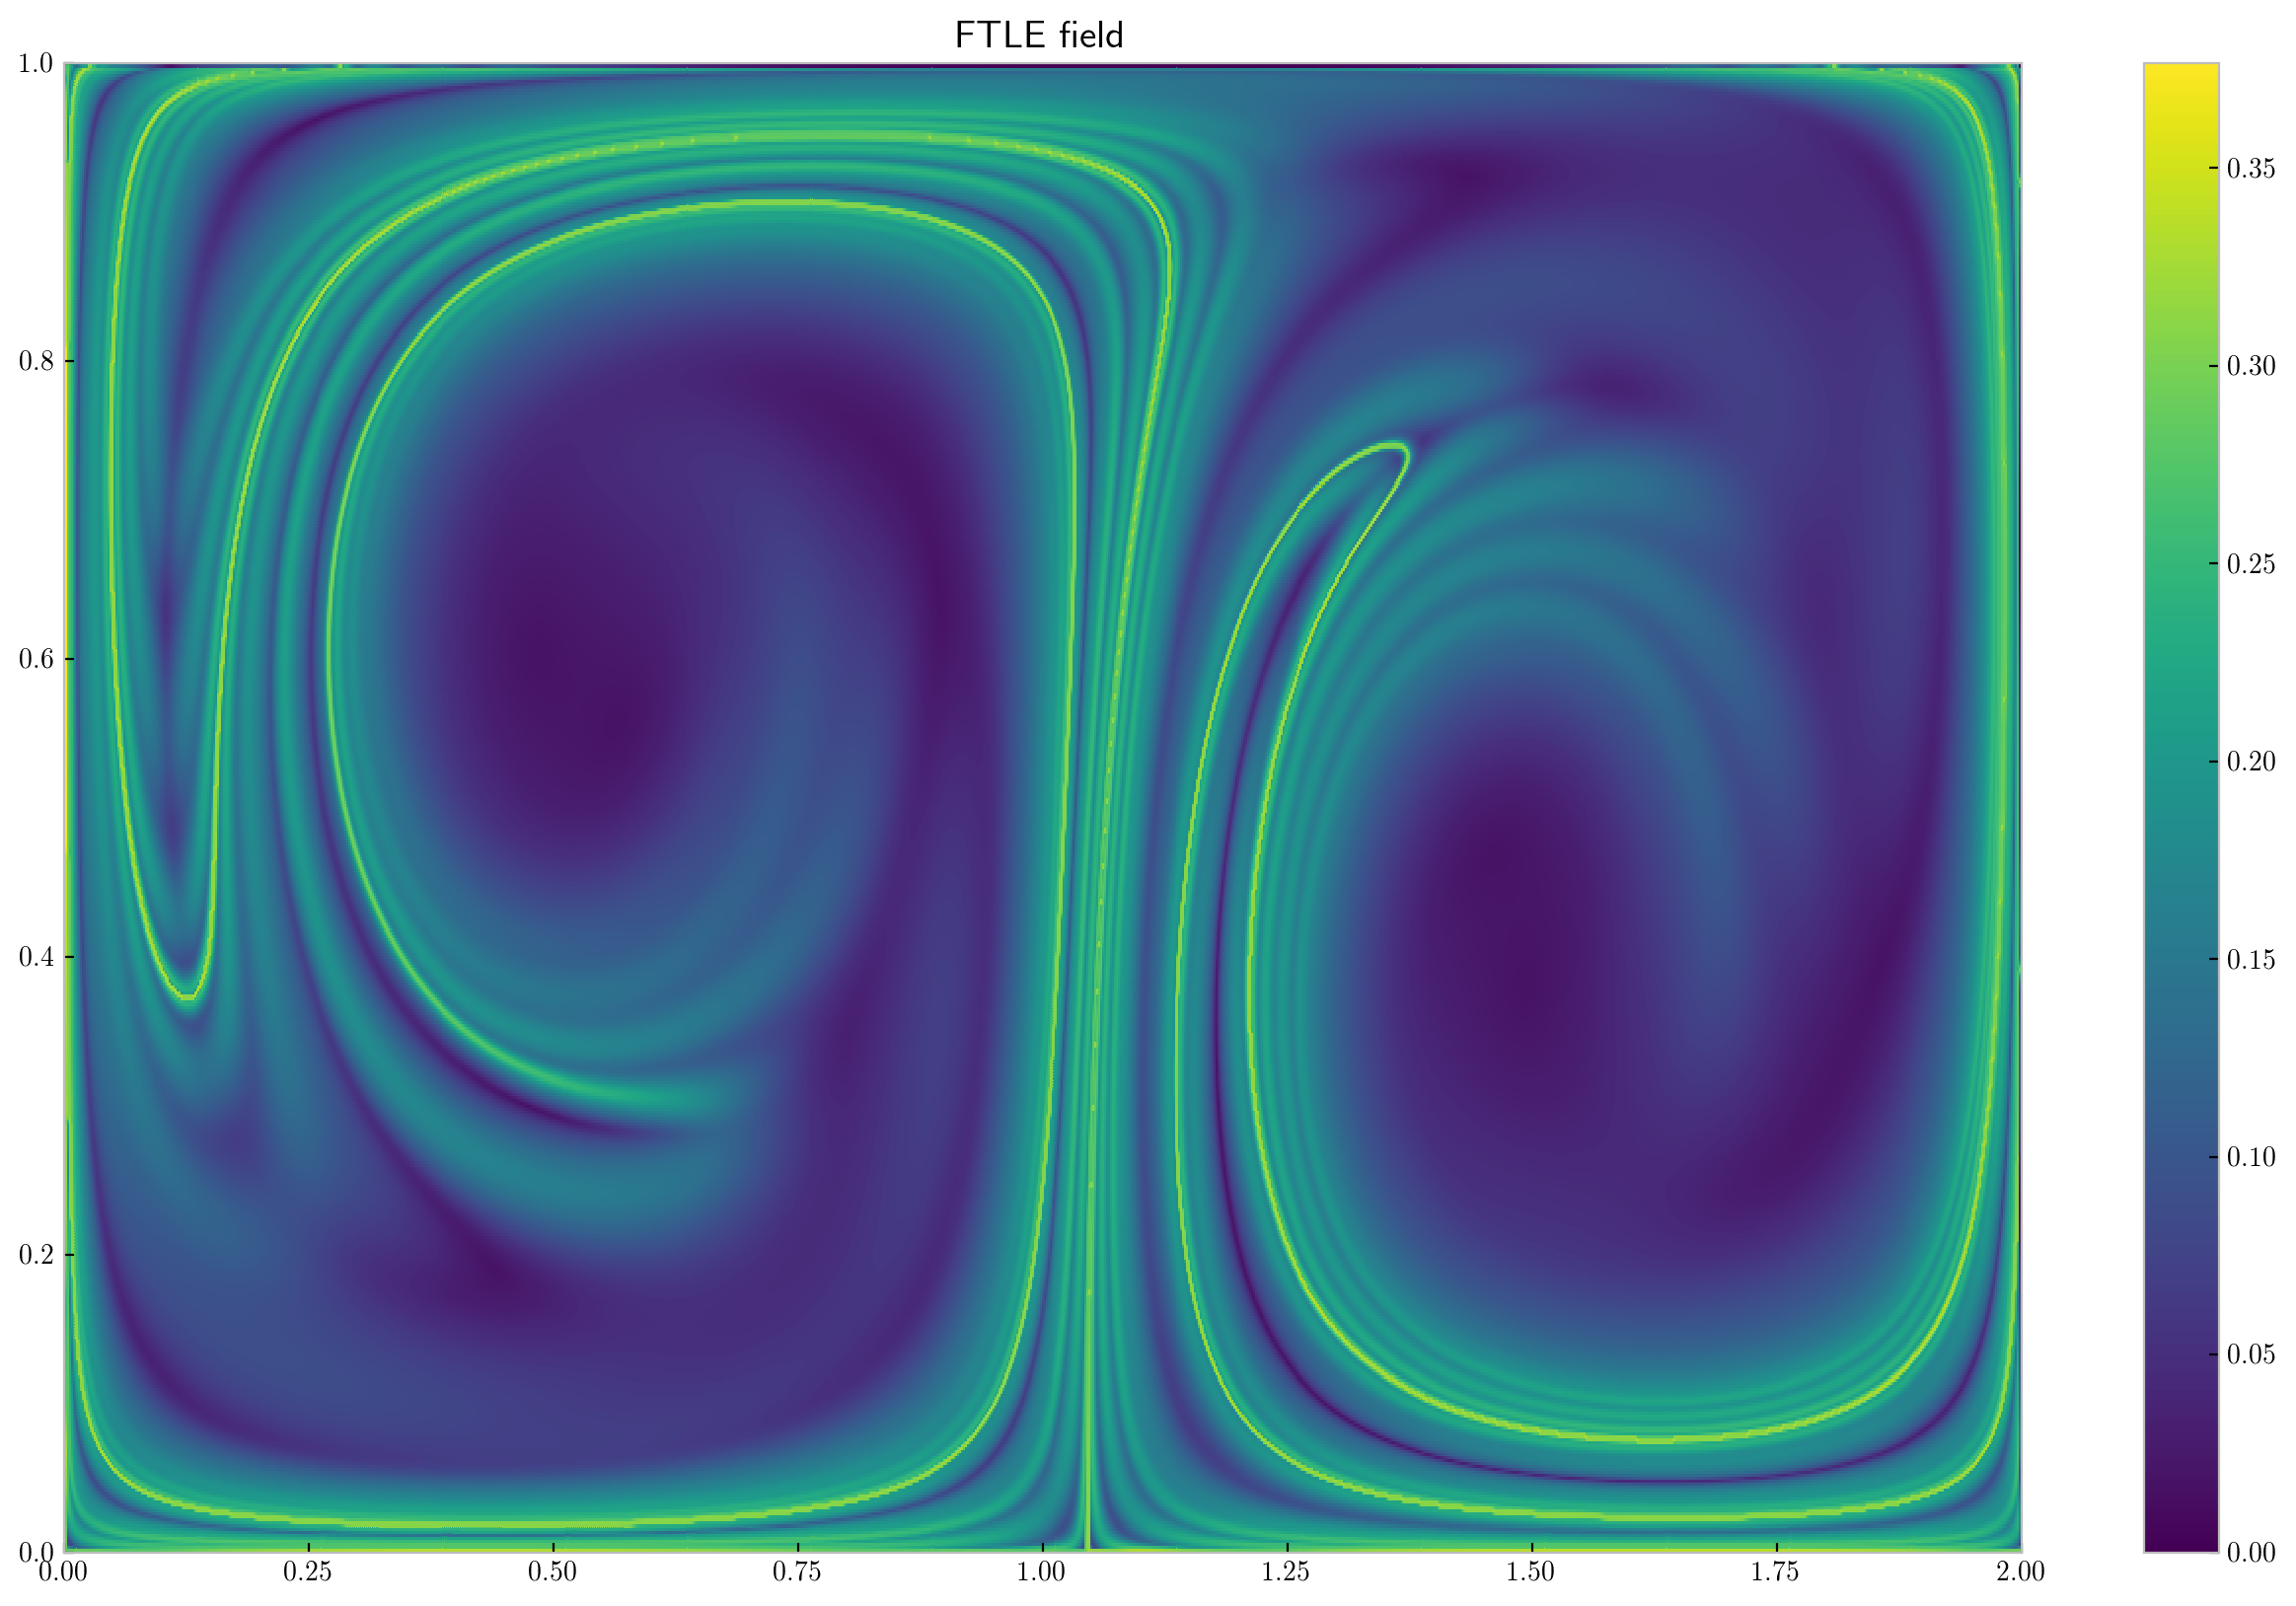

In [10]:
plt.figure(figsize = (16, 10), dpi = 200)
mesh = plt.pcolormesh(pos_init[0,:,:], pos_init[1,:,:], np.log(evals[0,:,:] + 1) / (2*np.abs(t_max - t_min)))
plt.colorbar(mesh)
plt.title(r'FTLE field')
plt.xlim(0,2)
plt.ylim(0,1)

In [26]:
C[:,:,2, 2]

array([[ 1828.72028319,  2125.61714902],
       [ 2125.61714902,  2473.42554133]])

In [50]:
evals[0,20,2]

3214.7405461824192

In [51]:
evals[1,20,2]

296.91118443573777

In [54]:
evecs[:,1,20,2]

array([-0.99772867,  0.0673609 ])

In [55]:
evecs[:,0,20,2]

array([ 0.0673609 ,  0.99772867])

In [49]:
evals[0,50,2]

4502.9308774508909

# Step 5: Identify initial points belonging to $\mathcal{G}_{0}$

## i.e., the points for which conditions A and B hold:

### A: $\lambda_{1}(\mathbf{x}_{0}) \neq \lambda_{2}(\mathbf{x}_{0}) > 1 $
### B: $\langle \mathbf{\xi}_{2}(\mathbf{x}_{0}), \nabla^{2} \lambda_2(\mathbf{x}_0) \mathbf{\xi}_2(\mathbf{x}_0) \rangle \leq 0$

In [60]:
A_true = np.logical_and(np.not_equal(evals[0,:,:], evals[1,:,:]), np.greater(evals[0,:,:], 1))

In [61]:
# Find laplacian of largest eigenvector:
d2V = np.empty((Nx, Ny))

# Second derivative, x-direction:
d2V[0,:] = (2*evals[0,0,:] - 5*evals[0,1,:] + 4*evals[0,2,:] - evals[0,3,:])/(dx**2)      # Second order accurate forward difference
d2V[1:-2,:] = (evals[0,2:-1,:] - 2*evals[0,1:-2,:] + evals[0,0:-3,:])/(dx**2)             # Centered difference
d2V[-1,:] = (2*evals[0,-1,:] - 5*evals[0,-2,:] + 4*evals[0,-3,:] - evals[0,-4,:])/(dx**2) # Second order accurate backward difference

# Adding second derivative, y-direction:
d2V[:,0] += (2*evals[0,:,0] - 5*evals[0,:,1] + 4*evals[0,:,2] - evals[0,:,3])/(dy**2)     # Second order accurate forward difference
d2V[:,1:-2] += (evals[0,:,2:-1] - 2*evals[0,:,1:-2] + evals[0,:,0:-3])/(dy**2)            # Centered difference
d2V[:,-1] += (evals[0,:,-1] - 5*evals[0,:,-2] + 4*evals[0,:,-3] - evals[0,:,-4])/(dy**2)  # Second order accurate backward difference

inner = np.sum(evecs[:,0,:,:] * d2V * evecs[:,0,:,:], axis = 0)
B_true = np.less_equal(inner, 0)

In [62]:
# Find laplacian of product between largest eigenvector and -value:
d2VV = np.empty((2, Nx, Ny))

# Second derivative, x-direction:
d2VV[0,0,:] = (2*evals[0,0,:]*evecs[0,0,0,:] - 5*evals[0,1,:]*evecs[0,0,1,:] + 4*evals[0,2,:]*evecs[0,0,2,:] - evals[0,3,:]*evecs[0,0,3,:])/(dx**2)      # Second order accurate forward difference
d2VV[0,1:-2,:] = (evals[0,2:-1,:]*evecs[0,0,2:-1,:] - 2*evals[0,1:-2,:]*evecs[0,0,1:-2,:] + evals[0,0:-3,:]*evecs[0,0,0:-3,:])/(dx**2)             # Centered difference
d2VV[0,-1,:] = (2*evals[0,-1,:]*evecs[0,0,-1,:] - 5*evals[0,-2,:]*evecs[0,0,-2,:] + 4*evals[0,-3,:]*evecs[0,0,-3,:] - evals[0,-4,:]*evecs[0,0,-4,:])/(dx**2) # Second order accurate backward difference

d2VV[1,0,:] = (2*evals[0,0,:]*evecs[1,0,0,:] - 5*evals[0,1,:]*evecs[1,0,1,:] + 4*evals[0,2,:]*evecs[1,0,2,:] - evals[0,3,:]*evecs[1,0,3,:])/(dx**2)      # Second order accurate forward difference
d2VV[1,1:-2,:] = (evals[0,2:-1,:]*evecs[1,0,2:-1,:] - 2*evals[0,1:-2,:]*evecs[1,0,1:-2,:] + evals[0,0:-3,:]*evecs[1,0,0:-3,:])/(dx**2)             # Centered difference
d2VV[1,-1,:] = (2*evals[0,-1,:]*evecs[1,0,-1,:] - 5*evals[0,-2,:]*evecs[1,0,-2,:] + 4*evals[0,-3,:]*evecs[1,0,-3,:] - evals[0,-4,:]*evecs[1,0,-4,:])/(dx**2) # Second order accurate backward difference

# Adding second derivative, y-direction:
d2VV[0,:,0] += (2*evals[0,:,0]*evecs[0,0,:,0] - 5*evals[0,:,1]*evecs[0,0,:,1] + 4*evals[0,:,2]*evecs[0,0,:,2] - evals[0,:,3]*evecs[0,0,:,3])/(dy**2)     # Second order accurate forward difference
d2VV[0,:,1:-2] += (evals[0,:,2:-1]*evecs[0,0,:,2:-1] - 2*evals[0,:,1:-2]*evecs[0,0,:,1:-2] + evals[0,:,0:-3]*evecs[0,0,:,0:-3])/(dy**2)            # Centered difference
d2VV[0,:,-1] += (evals[0,:,-1]*evecs[0,0,:,-1] - 5*evals[0,:,-2]*evecs[0,0,:,-2] + 4*evals[0,:,-3]*evecs[0,0,:,-3] - evals[0,:,-4]*evecs[0,0,:,-4])/(dy**2)  # Second order accurate backward difference

d2VV[1,:,0] += (2*evals[0,:,0]*evecs[1, 0,:,0] - 5*evals[0,:,1]*evecs[1,0,:,1] + 4*evals[0,:,2]*evecs[1,0,:,2] - evals[0,:,3]*evecs[1,0,:,3])/(dy**2)     # Second order accurate forward difference
d2VV[1,:,1:-2] += (evals[0,:,2:-1]*evecs[1,0,:,2:-1] - 2*evals[0,:,1:-2]*evecs[1,0,:,1:-2] + evals[0,:,0:-3]*evecs[1,0,:,0:-3])/(dy**2)            # Centered difference
d2VV[1,:,-1] += (evals[0,:,-1]*evecs[1,0,:,-1] - 5*evals[0,:,-2]*evecs[1,0,:,-2] + 4*evals[0,:,-3]*evecs[1,0,:,-3] - evals[0,:,-4]*evecs[1,0,:,-4])/(dy**2)  # Second order accurate backward difference

inner2 = np.sum(evecs[:,0,:,:] * d2VV, axis = 0)

B_true2 = np.less_equal(inner2, 0)

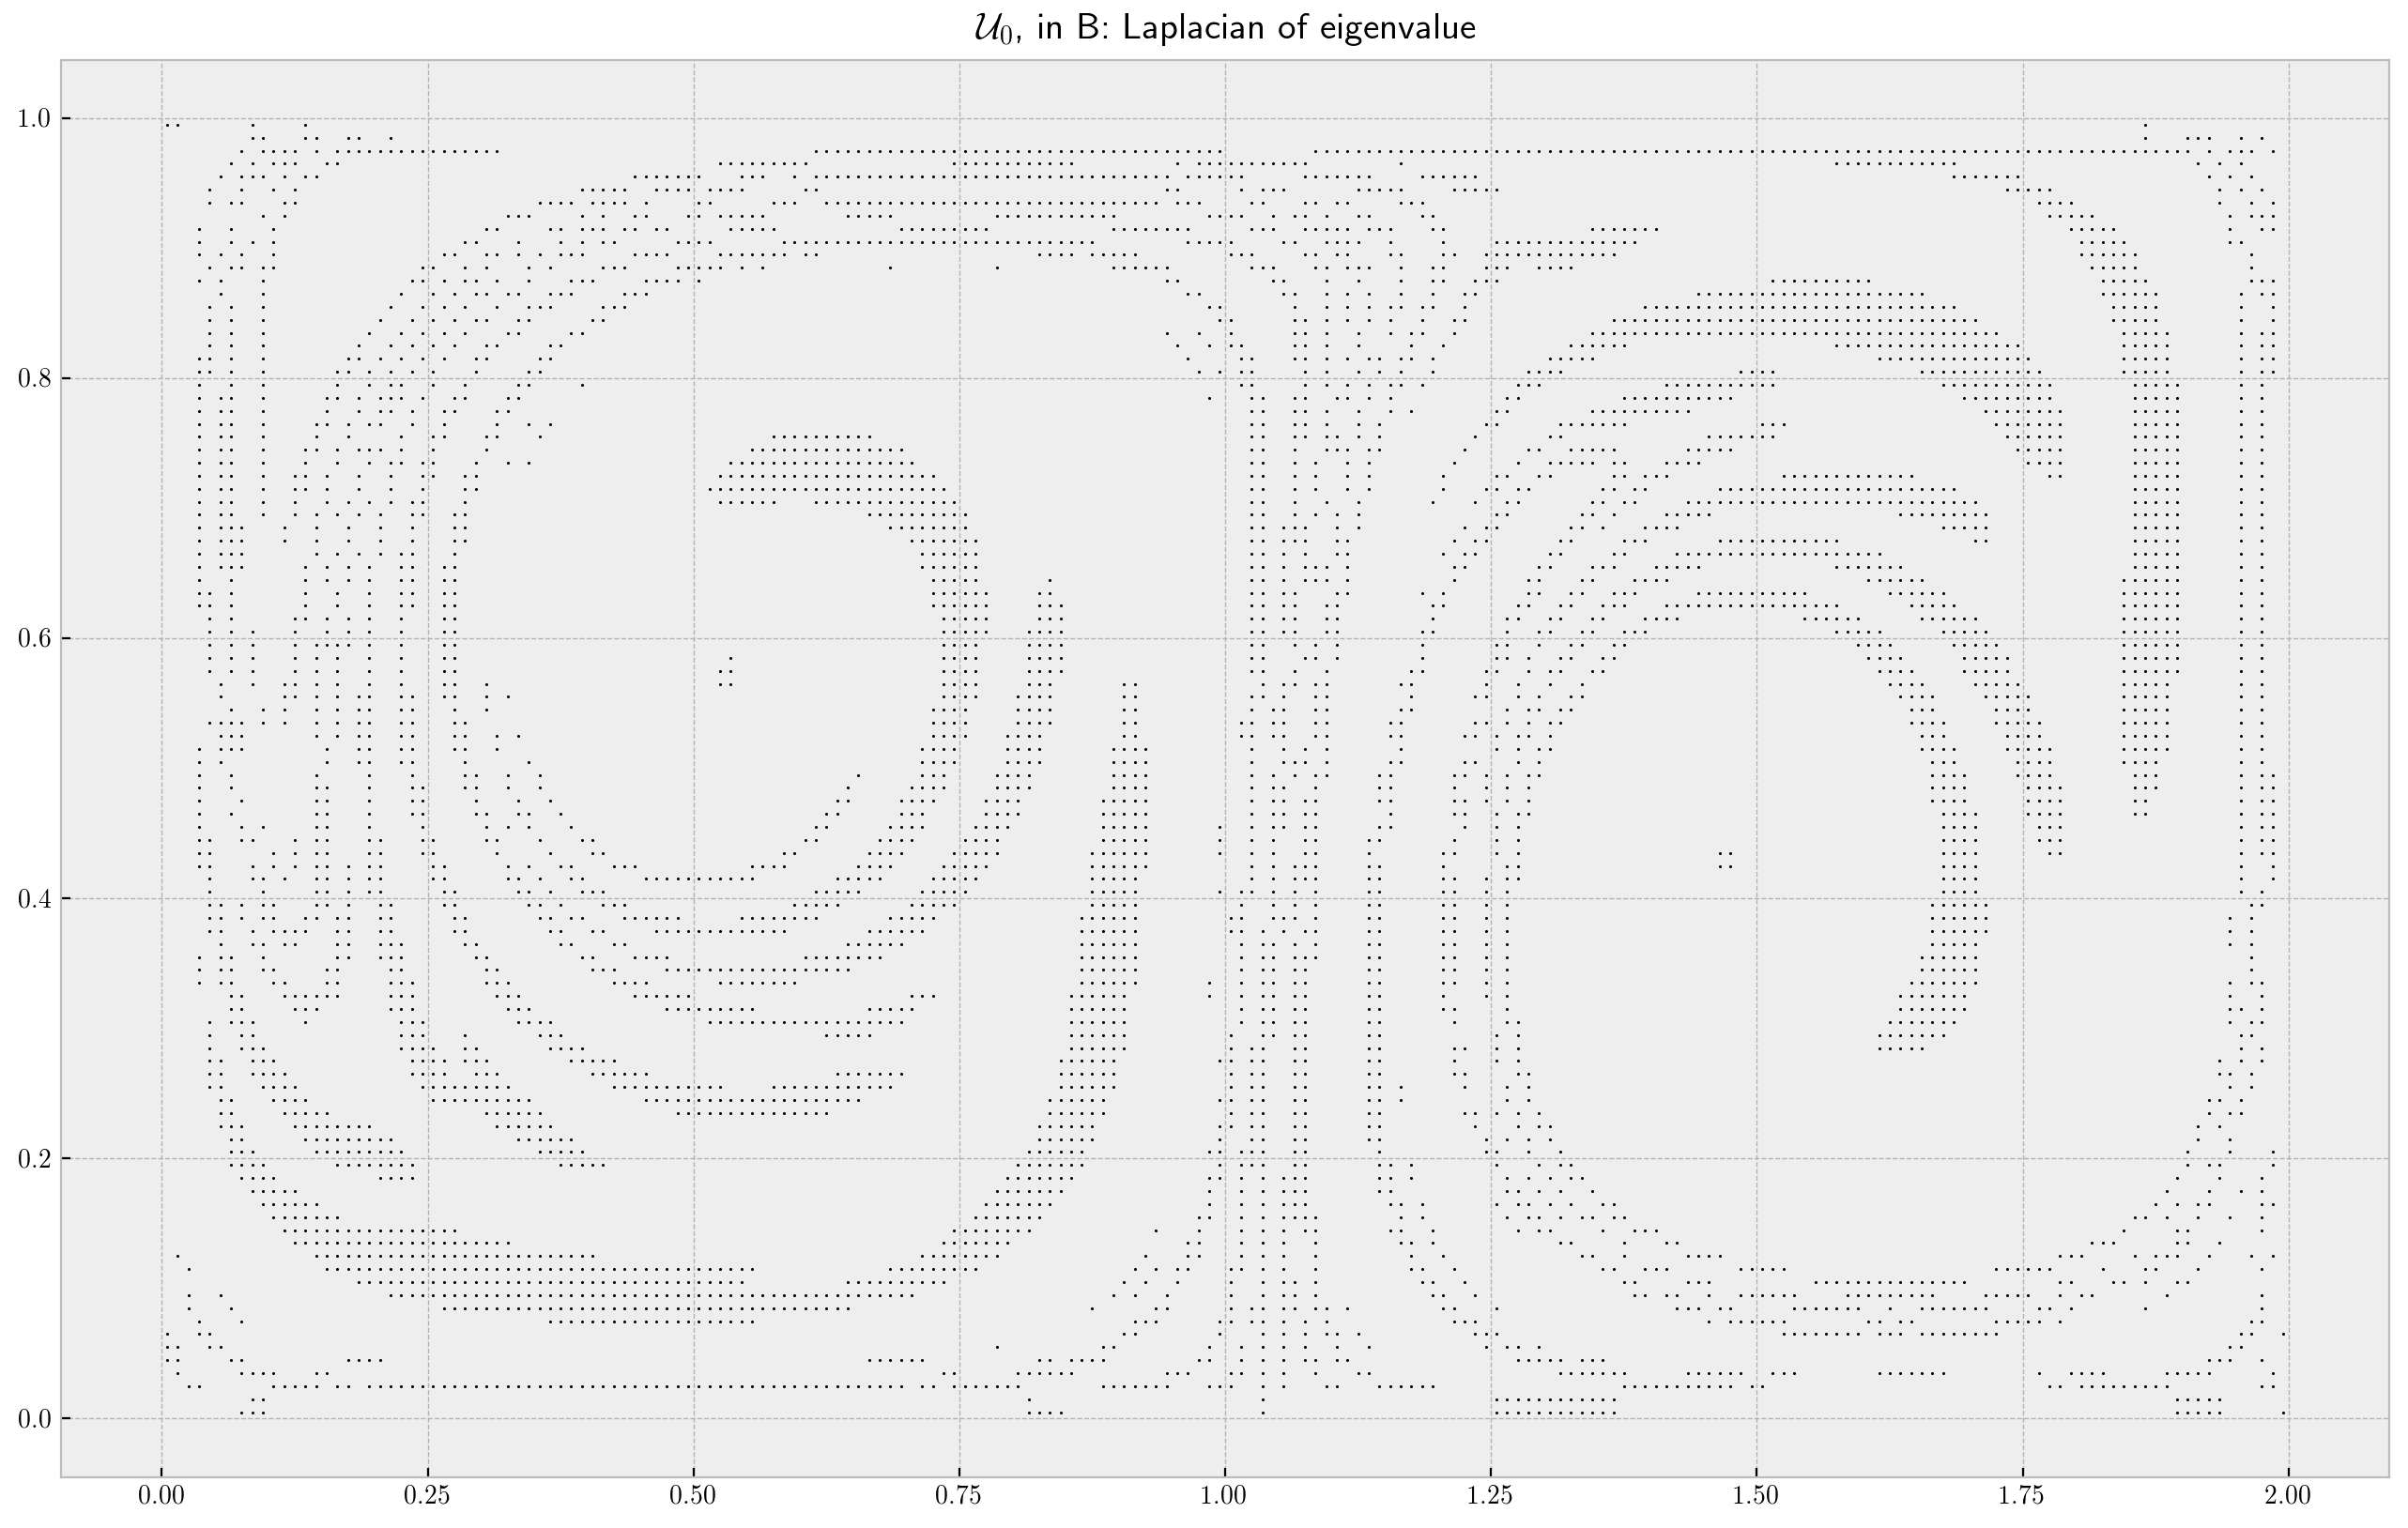

In [63]:
plt.figure(figsize = (16,10), dpi = 200)
plt.scatter(pos_init[0,np.logical_and(A_true,B_true)], pos_init[1,np.logical_and(A_true,B_true)], lw = 0, marker = '.', s = 5, color = 'k')
plt.title(r'$\mathcal{U}_{0}$, in B: Laplacian of eigenvalue')

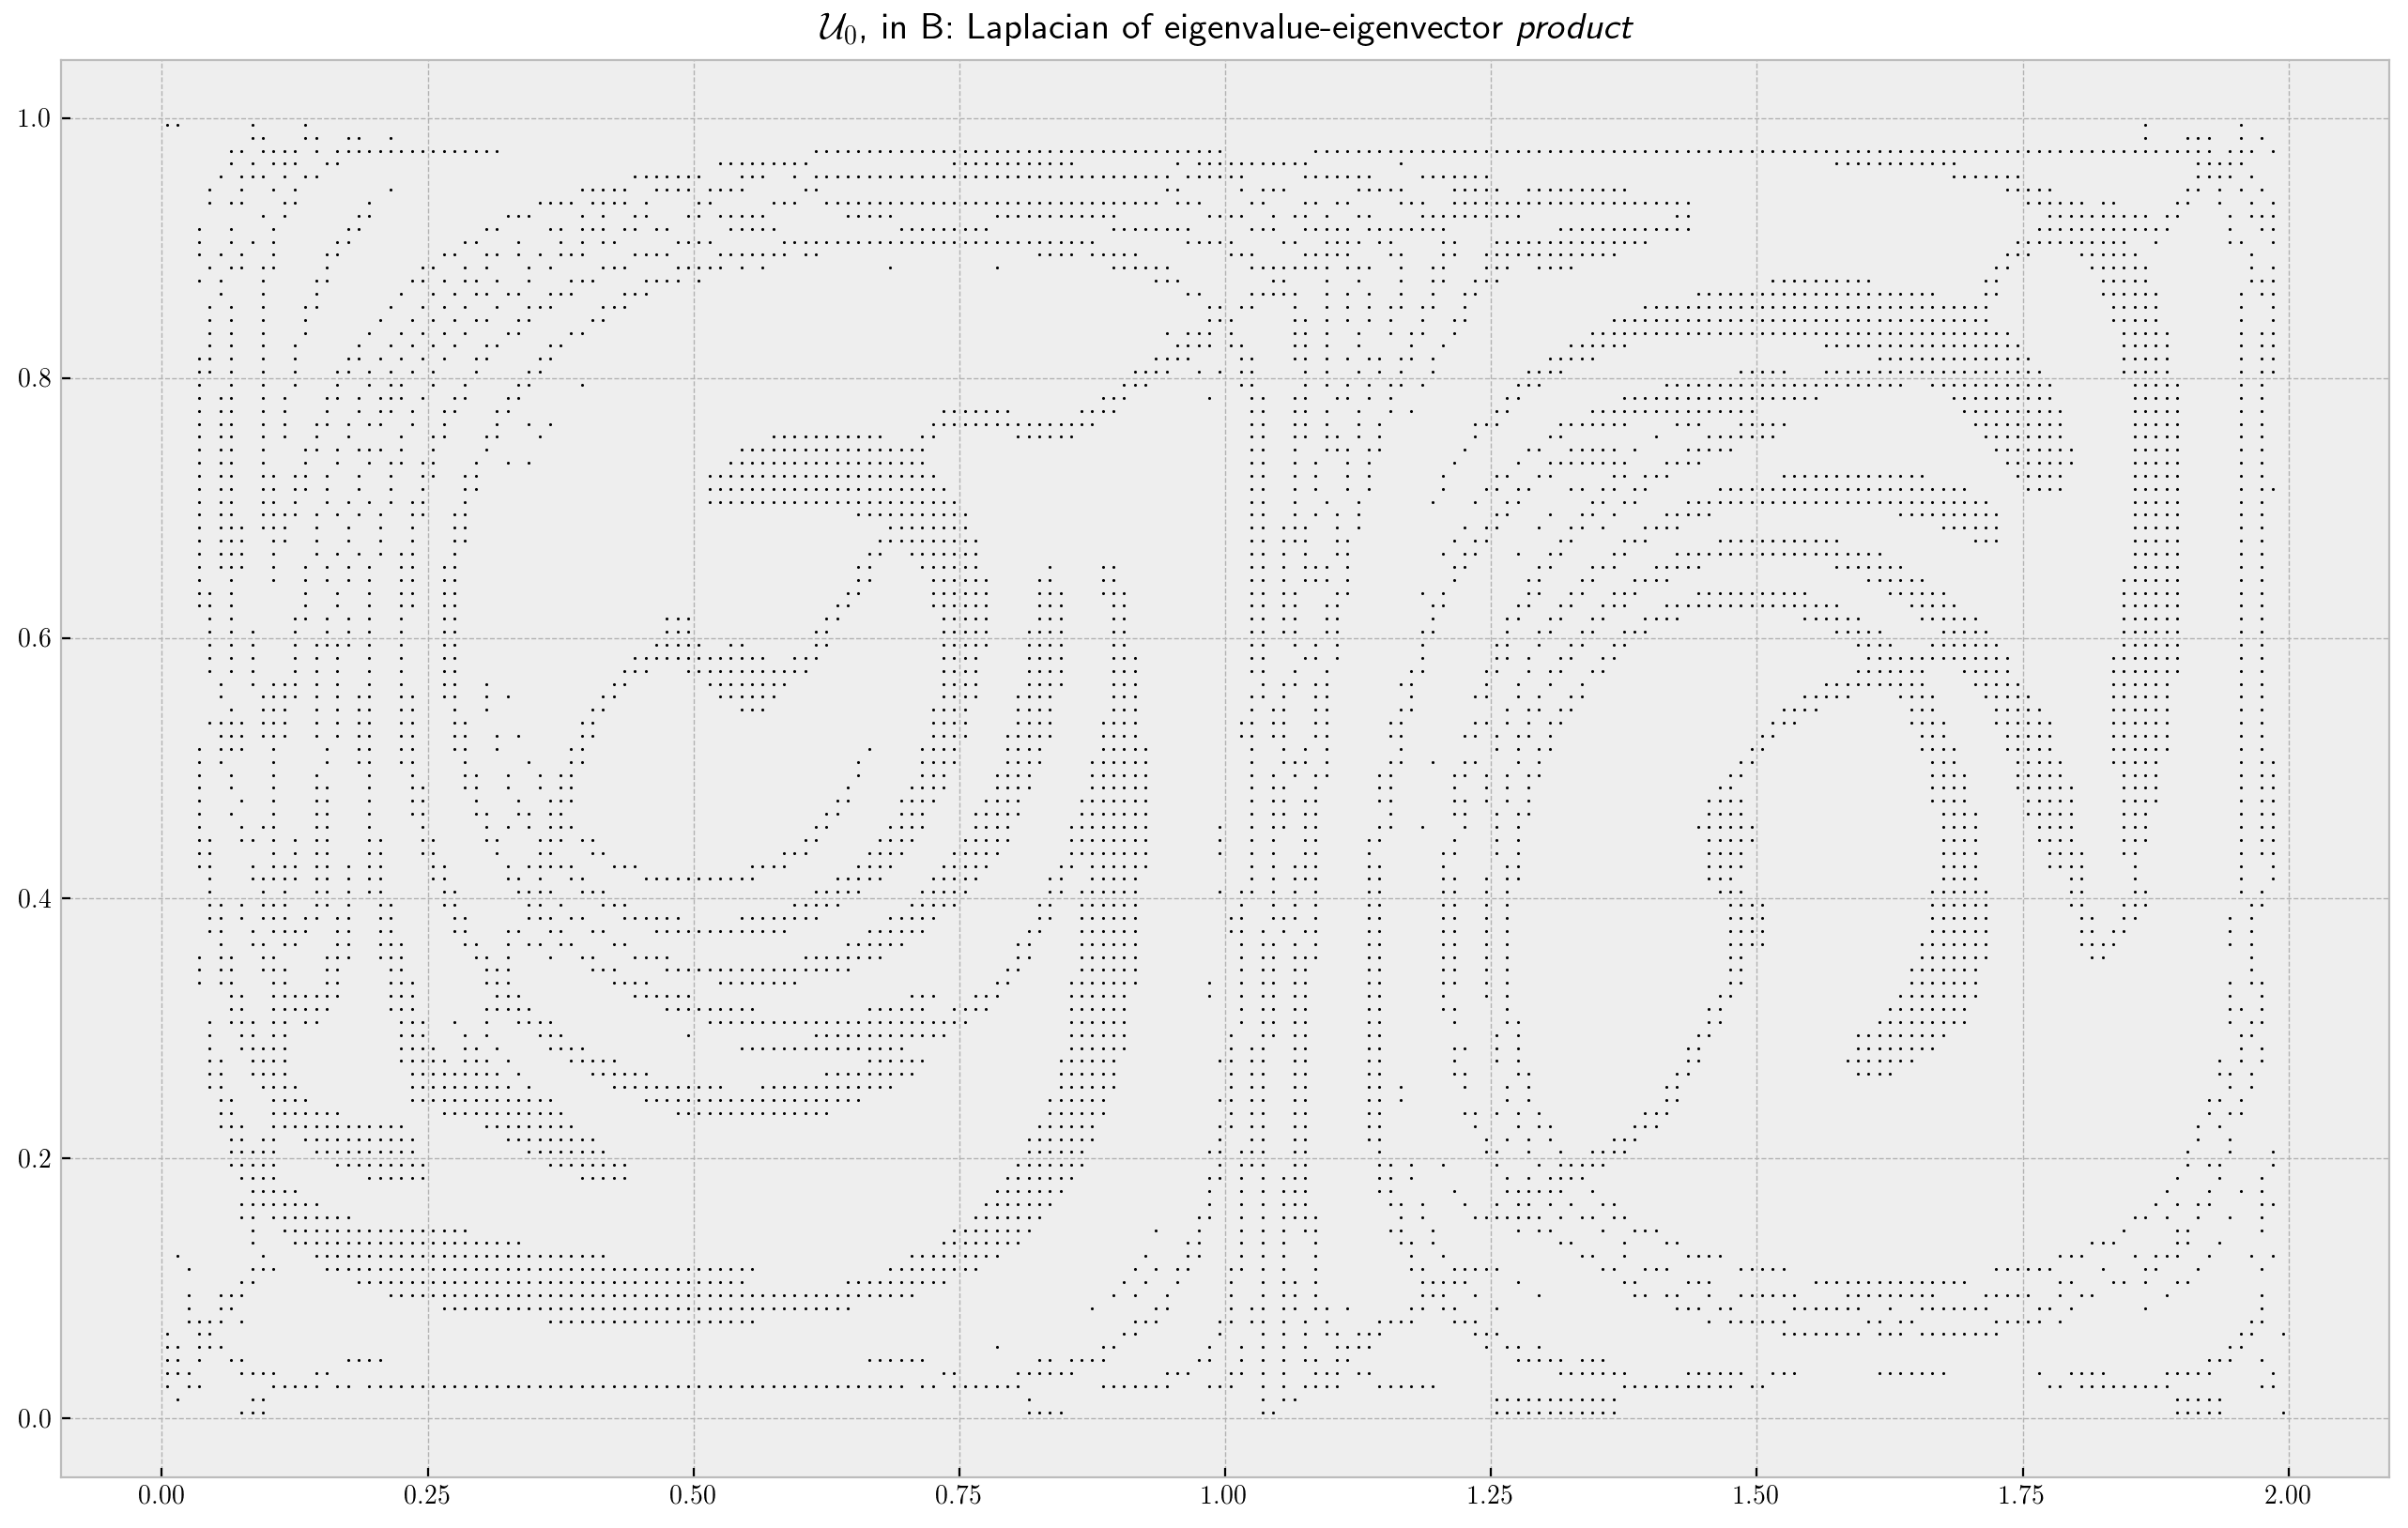

In [64]:
plt.figure(figsize = (16,10), dpi = 200)
plt.scatter(pos_init[0,np.logical_and(A_true,B_true2)], pos_init[1,np.logical_and(A_true,B_true2)], lw = 0, marker = '.', s = 5, color = 'k')
plt.title(r'$\mathcal{U}_{0}$, in B: Laplacian of eigenvalue-eigenvector \emph{product}')

# Step 6: Choose subset $\mathcal{G}_{0}$, as the intersection of $\mathcal{U}_{0}$ and four vertical and horizontal lines

In [65]:
mask = np.zeros((Nx, Ny), dtype = np.bool)

for i in range(1,5):
    mask[:, np.minimum(int(i*Ny/5), Ny - 1)] = True
    mask[np.minimum(int(i*Nx/5), Nx - 1), :] = True
    
one_mask_to_rule_them_all = np.logical_and(mask, np.logical_and(A_true, B_true))    

G_0 = pos_init[:, one_mask_to_rule_them_all]

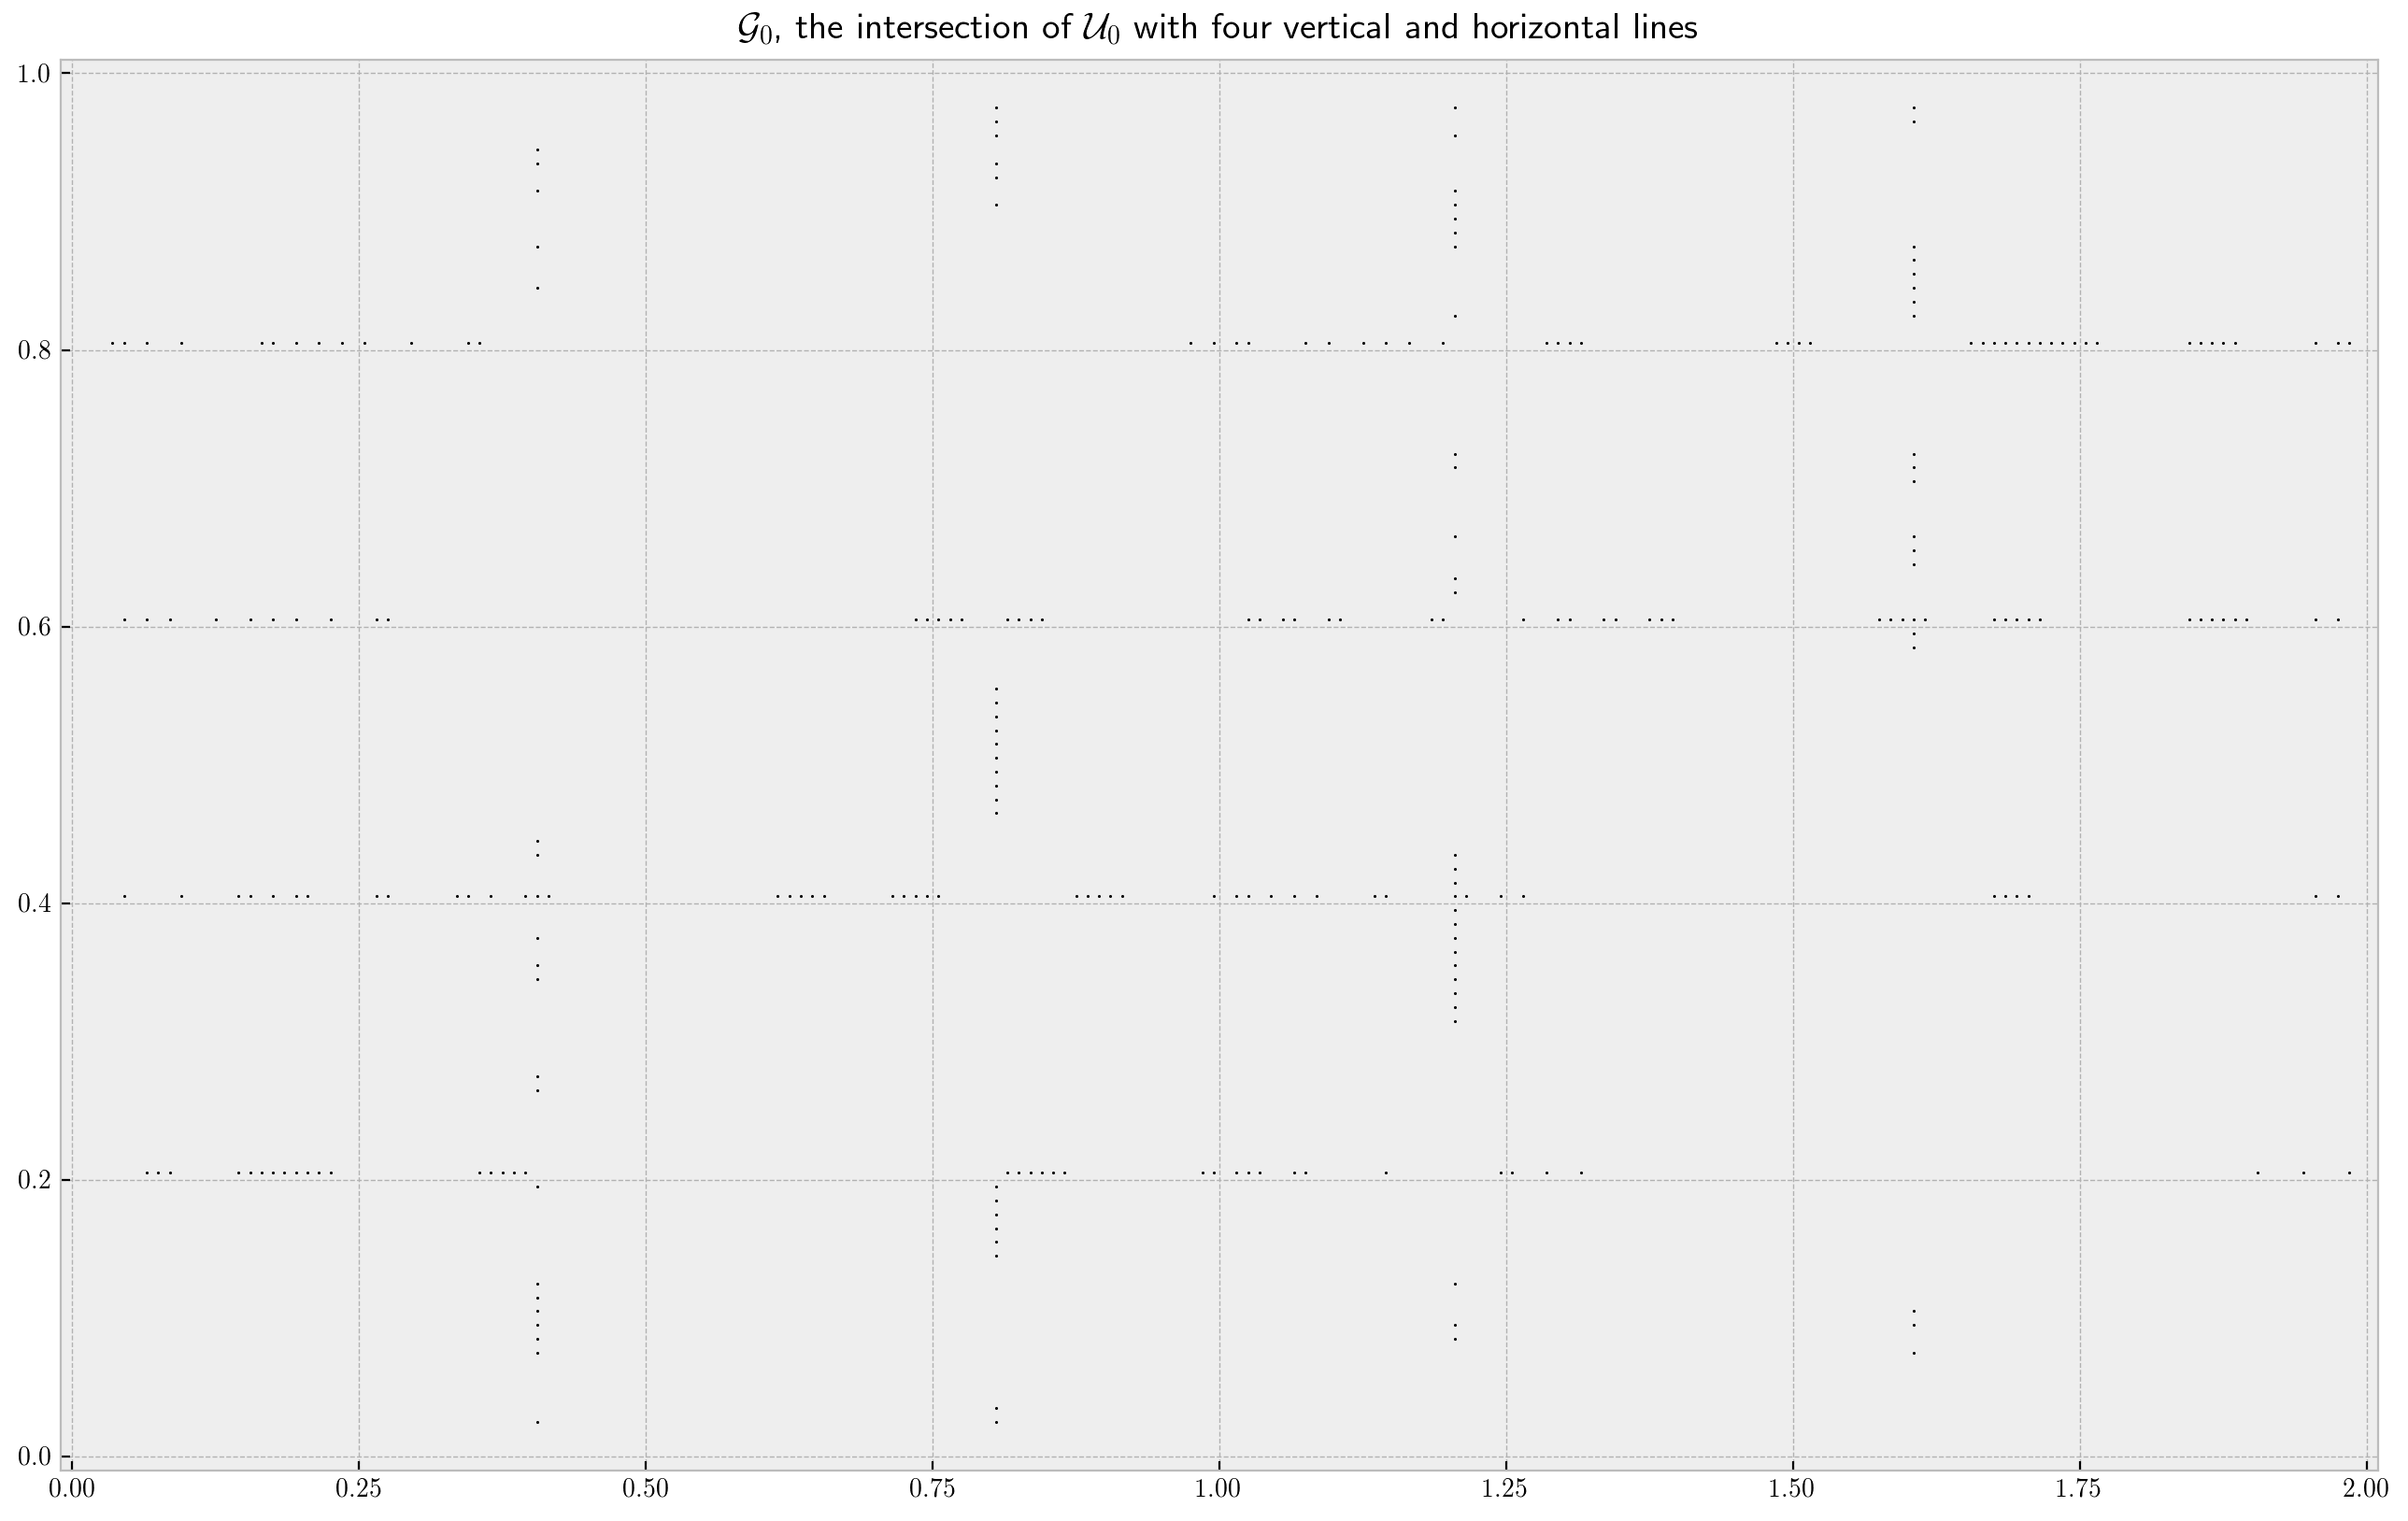

In [66]:
plt.figure(figsize = (16,10), dpi = 200)
plt.scatter(G_0[0], G_0[1], marker = '.', c = 'k', lw = 0, s = 5)
plt.xlim([-0.01, 2.01])
plt.ylim([-0.01, 1.01])
plt.title(r'$\mathcal{G}_{0}$, the intersection of $\mathcal{U}_{0}$ with four vertical and horizontal lines')

# Step 7: Define rescaled vector field from $\xi_{1}$ and advect the points in $\mathcal{G}_{0}$

## Using cubic splines:

In [18]:
smallest_eval_spline = RectBivariateSpline(pos_init[1,0,:], pos_init[0,:,0], evals[1,:,:].T)
largest_eval_spline  = RectBivariateSpline(pos_init[1,0,:], pos_init[0,:,0], evals[0,:,:].T)

smallest_evect_x_spline = RectBivariateSpline(pos_init[1,0,:], pos_init[0,:,0], evecs[0,1,:,:].T)
smallest_evect_y_spline = RectBivariateSpline(pos_init[1,0,:], pos_init[0,:,0], evecs[1,1,:,:].T)


In [136]:
class Rescaled():
    def __init__(self, smallest_eval_spline, largest_eval_spline, smallest_evect_x_spline, smallest_evect_y_spline):
        self.smallest_eval_spline = smallest_eval_spline
        self.largest_eval_spline = largest_eval_spline
        self.smallest_evect_x_spline = smallest_evect_x_spline
        self.smallest_evect_y_spline = smallest_evect_y_spline
        self.f_old = None
        
    def __call__(self, t, x):
        lambda1 = self.smallest_eval_spline.ev(x[1], x[0])
        lambda2 = self.largest_eval_spline.ev(x[1], x[0])
        alpha = ((lambda2 - lambda1)/(lambda2 + lambda1))**2
        evec_x = self.smallest_evect_x_spline.ev(x[1], x[0])
        evec_y = self.smallest_evect_y_spline.ev(x[1], x[0])
        length = np.sqrt(evec_x**2 + evec_y**2)
        
        #evec_x /= length
        #evec_y /= length
        
        if self.f_old is None:
            sign = 1
        else:
            sign = np.sign(np.sum(self.f_old * alpha * np.array([evec_x, evec_y])))
            

        return np.array([sign*alpha*evec_x, sign*alpha*evec_y])

In [137]:
T = 10.
t = 0.
h = 0.1

foo = Rescaled(smallest_eval_spline, largest_eval_spline, smallest_evect_x_spline, smallest_evect_y_spline)

G = np.copy(G_0)


ts = np.ones(np.shape(G)[1]) * t
hs = np.ones(np.shape(G)[1]) * h



traj = []

integration_mask = np.less(ts, T)

integrator = rk4

#for i in range(int((T-t)/h)):
while np.any(integration_mask):
    traj.append(G)
    foo.f_old = foo(ts[integration_mask], G[:,integration_mask])
    hs[integration_mask] = np.minimum(hs[integration_mask], T - ts[integration_mask])
    ts[integration_mask], G[:, integration_mask], hs[integration_mask] = integrator(ts[integration_mask], G[:, integration_mask], hs[integration_mask], foo)
    #G[:, integration_mask] = tmp
    integration_mask = np.less(ts, T)
    #traj.append(G)
    #print(np.sum(integration_mask))

In [142]:
G[:, np.less(np.ones(np.shape(G)[1])*t, T)].shape

(2, 1359)

In [99]:
traj[-1]

array([[  9.44347442e-01,   1.08729463e+00,   9.60659680e-01, ...,
          2.32504502e+00,   2.35686182e+00,   2.50789152e+00],
       [ -4.61654600e-01,  -3.67973433e-01,  -4.37142930e-01, ...,
         -1.08604431e-03,   1.22539882e-01,   1.86270674e-01]])

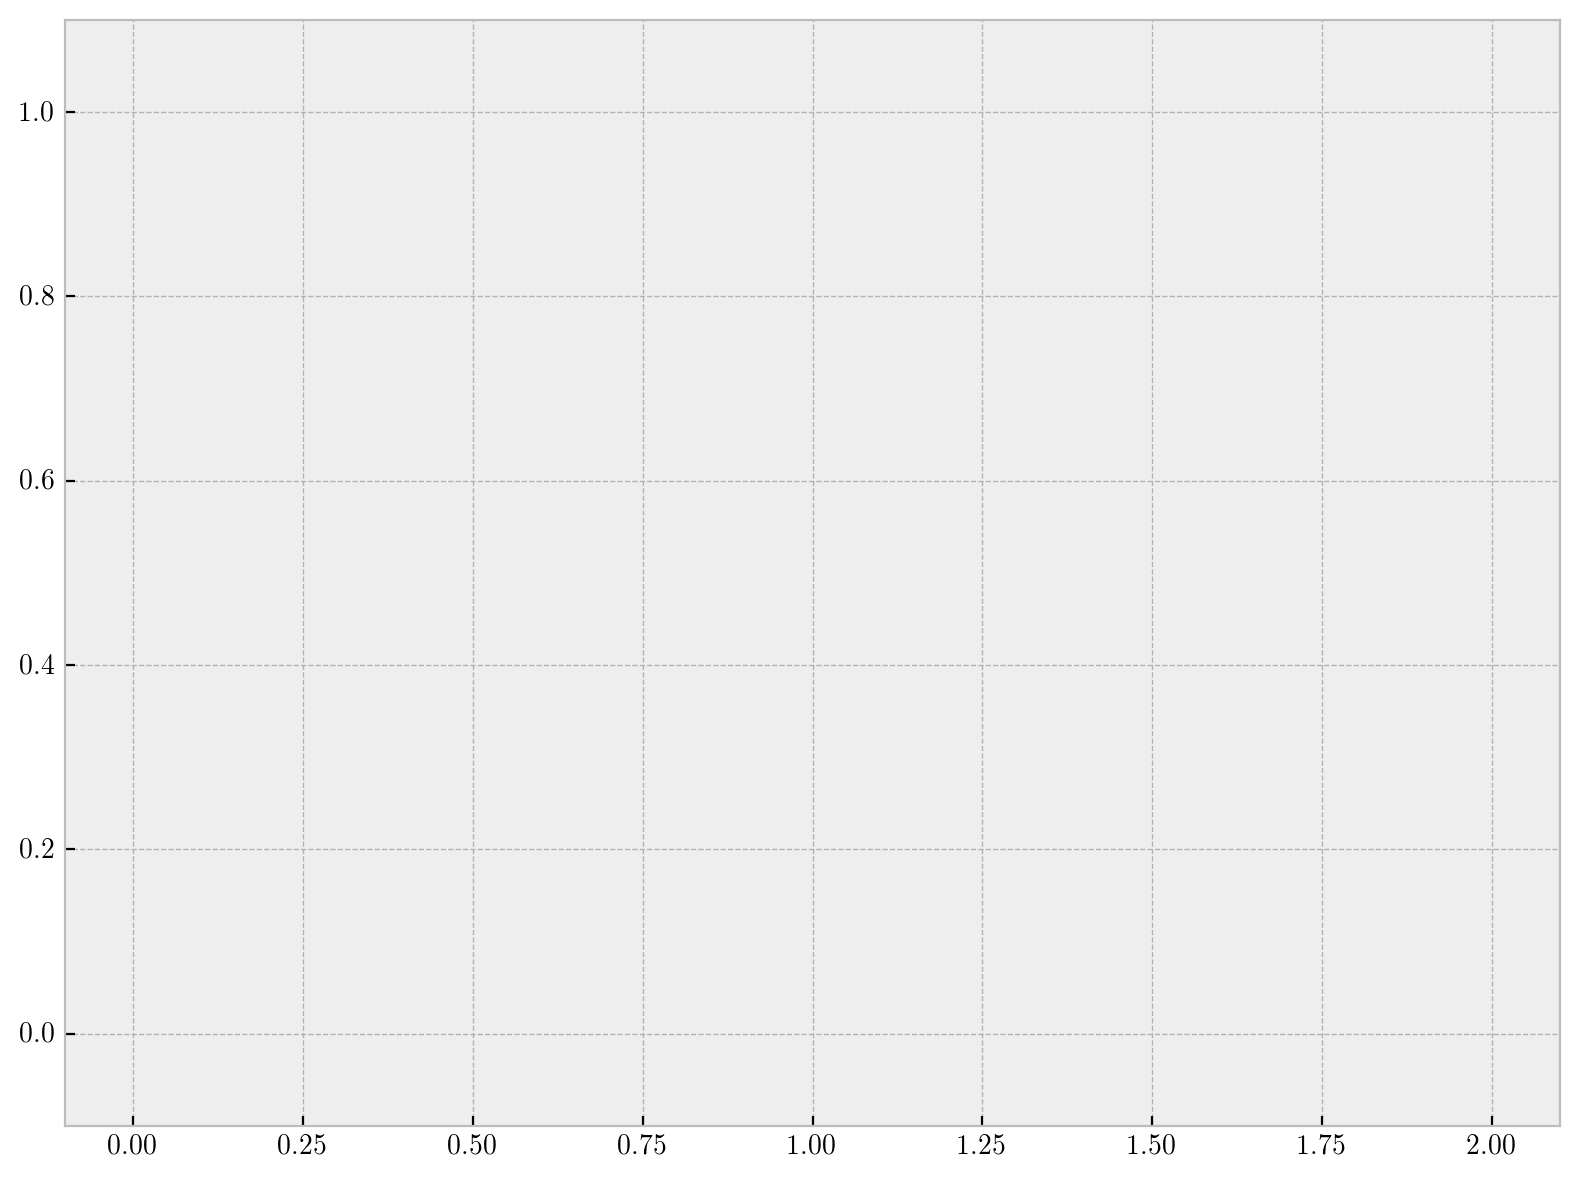

In [139]:
plt.figure(figsize = (8,6), dpi = 200)
t2 = np.asarray(traj)

#plt.spy(B_true[:, ::-1].T)
#plt.spy(one_mask_to_rule_them_all[:,::-1].T)
for j in range(np.shape(t2)[2]):
    plt.plot(t2[:,0,j], t2[:,1,j], c = 'k', lw = 1, alpha = 0.5)

plt.xlim([-0.1, 2.1])
plt.ylim([-0.1, 1.1])

plt.tight_layout()

In [135]:
one_mask_to_rule_them_all.shape

(1000, 500)

## Using special-purpose linear interpolation:

In [60]:
class LinearSpecial():
    def __init__(self, xc, yc, xi):
        self.xc = xc
        self.yc = yc
        self.dx = xc[-1]- xc[-2]
        self.dy = yc[-1] - yc[-2]
        self.xi = xi
        self.Nx = np.size(xc)
        self.Ny = np.size(yc)
        self.fold = None
        #print(np.shape(xi))
        #print(np.shape(self.xi))
        
    def __call__(self, t, x):
        # Calculate indices for lower left corner in cell:
        i = int(x[0]/self.dx)
        j = int(x[1]/self.dy)
        
        # If outside the domain, move inside:
        i = np.minimum(i, Nx - 2)
        j = np.minimum(j, Ny - 2)
        
        # Use the lower left corner as reference, calculate 
        # the rotation of the other vectors, and rotate by
        # 180 degrees if necessary (due to oriental 
        # discontinuity)
        subxi = np.zeros((2, 2, 2))
        subxi[:] = self.xi[:, i:i+2, j:j+2]
        
        #print(np.shape(self.xi[:, i:i+2, j:j+2]))
        
        for n in range(2):
            for m in range(2):
                if np.logical_and(np.equal(n,m), np.equal(n,0)):
                    pass
                else:
                    # Flip direction if dot product is negative
                    subxi[:,n,m] = np.sign(np.dot(subxi[:,0,0], subxi[:,n,m])) * subxi[:,n,m]
                    
        # Linear interpolarion:
        W = np.zeros((1,2,2))
        W[0,0,0] = self.xc[i+1] - x[0]
        W[0,0,1] = 1 - W[0,0,0]
        W[0,1,0] = self.yc[j+1] - x[1]
        W[0,1,1] = 1 - W[0,1,0]
        
        V = np.sum(W * subxi, axis = (1,2))
        
        V /= np.sqrt(V[0]**2 + V[1]**2)
        
        # Check orientation against previous vector:
        if self.fold is None:
            return V
        else:
            # If dot product is negative, flip sign:
            return np.sign(np.dot(self.fold, V)) * V

In [175]:
bar = LinearSpecial(pos_init[0,:,0], pos_init[1,0,:], evecs[:,1,:,:])

# Loop over all initial conditions
# If (A and B), check if point 
# corresponds to a local max.
# of lambda_2 (largest eigval)

r = 0.01

LCSs = []

#progressbar = FloatProgress(min = 0, max = Nx)
#display(progressbar)

for i in range(Nx):
    print('{}th of {} rows'.format(i, Nx))
    #progressbar.value = i
    for j in range(Ny):
        if np.logical_and(A_true, B_true)[i,j]:
            
            # Re-initialize the derivative function:
            bar.fold = None
            
            dists = np.sum((pos_init[:,i,j].reshape(2,1,1) - pos_init)**2, axis = 0)
            if np.less(evals[0,i,j], np.amax(evals[0,:,:][np.less(dists, r)])):
                pass
            else:
                T = 5
                t = 0
                h = 0.0001
                Nt = int((T-t)/h)
                
                l_min = 1
                l = 0
                
                l_filter = 0.2
                l_out = 0
                
                xs = np.zeros((2, Nt))
                xs[:,0] = pos_init[:, i, j]
                
                for n in range(1, Nt):
                    bar.fold = bar(t, xs[:, n-1])
                    t, tmp, h = rk4(t, xs[:, n-1], h, bar)
                    xs[:, n] = tmp
                    if np.greater(ABspline.ev(tmp[1], tmp[0]), 1e-2):
                        l_out += np.sqrt((xs[0,n] - xs[0,n-1])**2 + (xs[1,n] - xs[1,n-1])**2)
                    else:
                        l_out = 0
                    
                    if l_out > l_filter or np.logical_or(np.logical_or(np.less(xs[0,n], 0.)), np.greater(xs[0,n], 2.)), np.logical_or(np.less(xs[1,n], 0.), np.greater(xs[1,n], 1.))):
                        break
                    l += np.sqrt((xs[0,n] - xs[0,n-1])**2 + (xs[1,n] - xs[1,n-1])**2)
                
                if np.greater(l, l_min):
                    LCSs.append(xs[:,:n])
                    print(len(LCSs))
                #print(i*Nx + j)

0th of 1000 rows
1th of 1000 rows
2th of 1000 rows
3th of 1000 rows
4th of 1000 rows
5th of 1000 rows
6th of 1000 rows
7th of 1000 rows
8th of 1000 rows
9th of 1000 rows
10th of 1000 rows
11th of 1000 rows
12th of 1000 rows
13th of 1000 rows
14th of 1000 rows
15th of 1000 rows
16th of 1000 rows
17th of 1000 rows
18th of 1000 rows
19th of 1000 rows
20th of 1000 rows
21th of 1000 rows
22th of 1000 rows
23th of 1000 rows
24th of 1000 rows
25th of 1000 rows
26th of 1000 rows
27th of 1000 rows
28th of 1000 rows
29th of 1000 rows
30th of 1000 rows
31th of 1000 rows
32th of 1000 rows
33th of 1000 rows
34th of 1000 rows
35th of 1000 rows
36th of 1000 rows
37th of 1000 rows
38th of 1000 rows
39th of 1000 rows
40th of 1000 rows
41th of 1000 rows
42th of 1000 rows
43th of 1000 rows
44th of 1000 rows
45th of 1000 rows
46th of 1000 rows
47th of 1000 rows
48th of 1000 rows
49th of 1000 rows
50th of 1000 rows
51th of 1000 rows
52th of 1000 rows
53th of 1000 rows
54th of 1000 rows
55th of 1000 rows
56

ValueError: invalid number of arguments

In [173]:
#ABspline = RectBivariateSpline(pos_init[1,0,:], pos_init[0,:,0], np.logical_and(A_true, B_true).T)
#ABspline.ev(pos_init[1,0,0], pos_init[0,0,0])

array(6.461575256216498e-23)

In [170]:
#bar = LinearSpecial(pos_init[0,:,0], pos_init[1,0,:], evecs[:,1,:,:])

# Loop over all initial conditions
# If (A and B), check if point 
# corresponds to a local max.
# of lambda_2 (largest eigval)

#r = 0.01

#LCSs = []

#eigenvals_in_G_0 = evals[0,one_mask_to_rule_them_all]

#progressbar = FloatProgress(min = 0, max = Nx)
#display(progressbar)

#for i in range(G_0.shape[1]):
    #progressbar.value = i
    #for j in range(Ny):
        #if one_mask_to_rule_them_all[i,j]:
            
    # Re-initialize the derivative function:
#    bar.fold = None
            
#    dists = np.sum((G_0[:,i].reshape(2,1,1) - pos_init)**2, axis = 0)
#    if np.less(eigenvals_in_G_0[i], np.amax(evals[0,:,:][np.less(dists, r)])):
        #print(i)
#        pass
        
#    else:
#        T = 5
#        t = 0
#        h = 0.0001
#        Nt = int((T-t)/h)
                
#        xs = np.zeros((2, Nt))
#        xs[:,0] = G_0[:,i]
                
#        for n in range(1, Nt):
#            bar.fold = bar(t, xs[:, n-1])
#            t, tmp, h = rk4(t, xs[:, n-1], h, bar)
#            xs[:, n] = tmp
#            if np.logical_or(np.logical_or(np.less(xs[0,n], 0.), np.greater(xs[0,n], 2.)), np.logical_or(np.less(xs[1,n], 0.), np.greater(xs[1,n], 1.))):
#                break
                
#        LCSs.append(xs[:,:n])
#        print(len(LCSs))
        #print(i*Nx + j)

In [ ]:
np.amax(evals[0,:,:][dists < r])

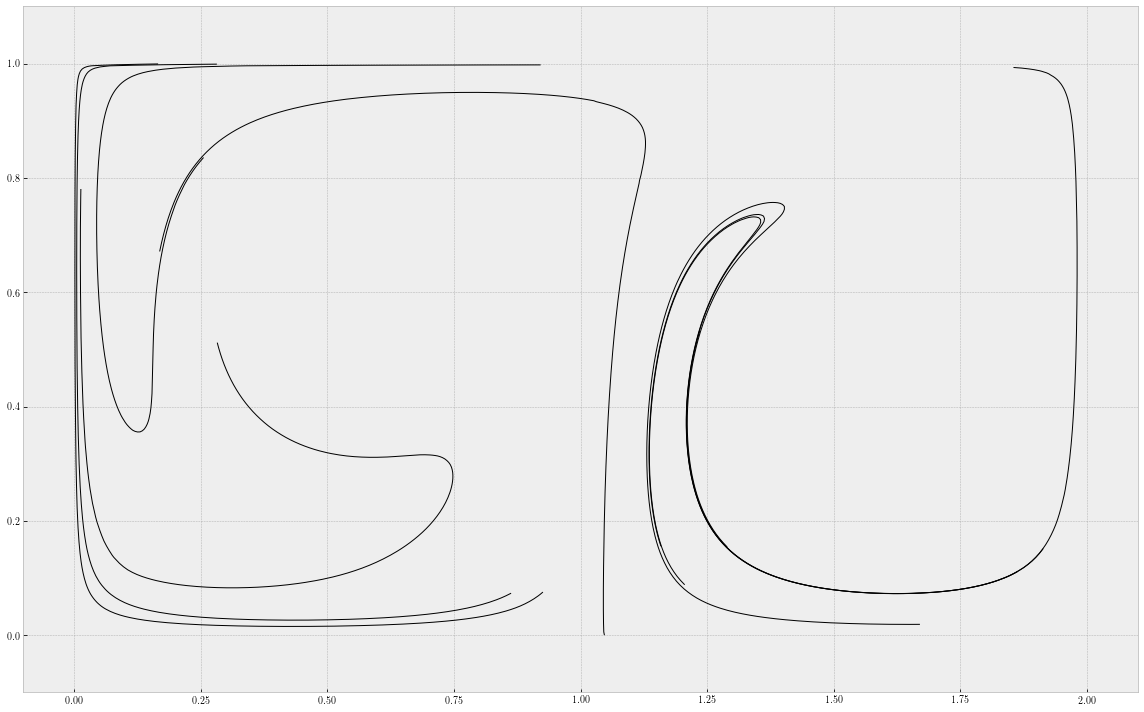

In [169]:
plt.figure(figsize = (16, 10))

for i in range(len(LCSs)):
    plt.plot(LCSs[i][0,:], LCSs[i][1,:], c = 'k', lw = 1)
    
plt.xlim([-0.1, 2.1])
plt.ylim([-0.1, 1.1])

plt.tight_layout()

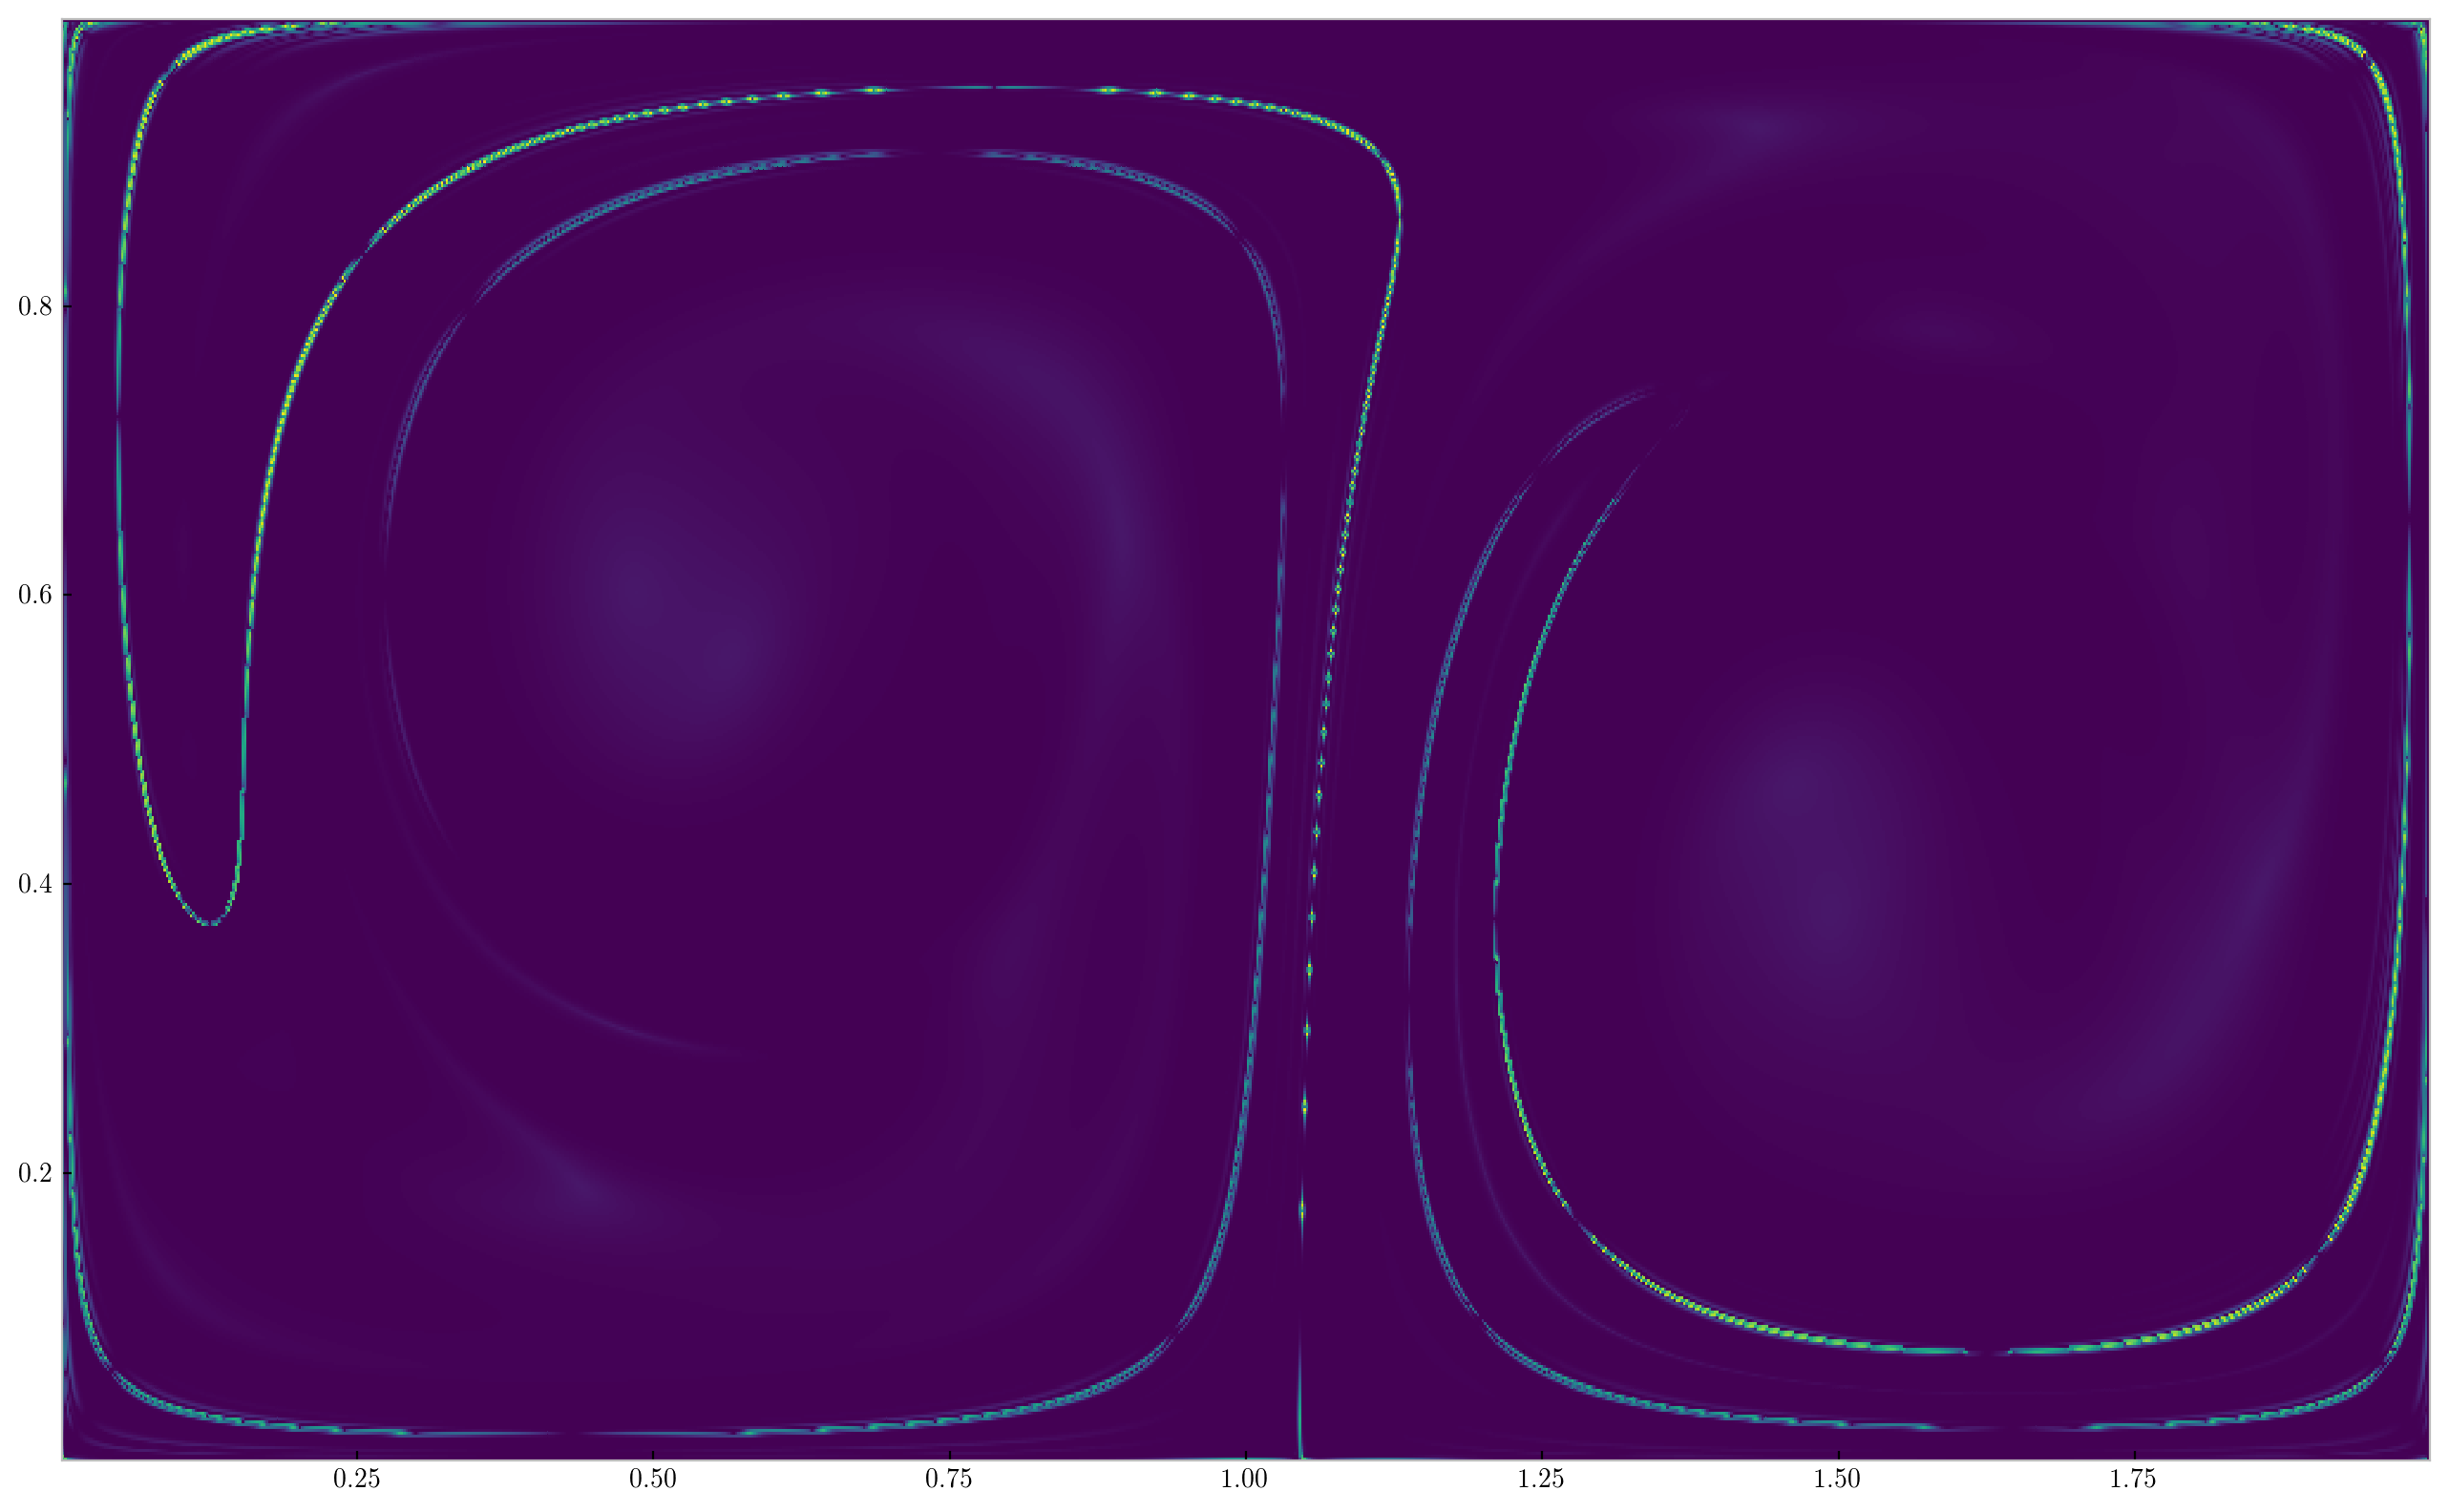

In [134]:
plt.figure(figsize = (16,10), dpi = 200)
plt.pcolormesh(pos_init[0], pos_init[1], np.log(evals[1] + 1))

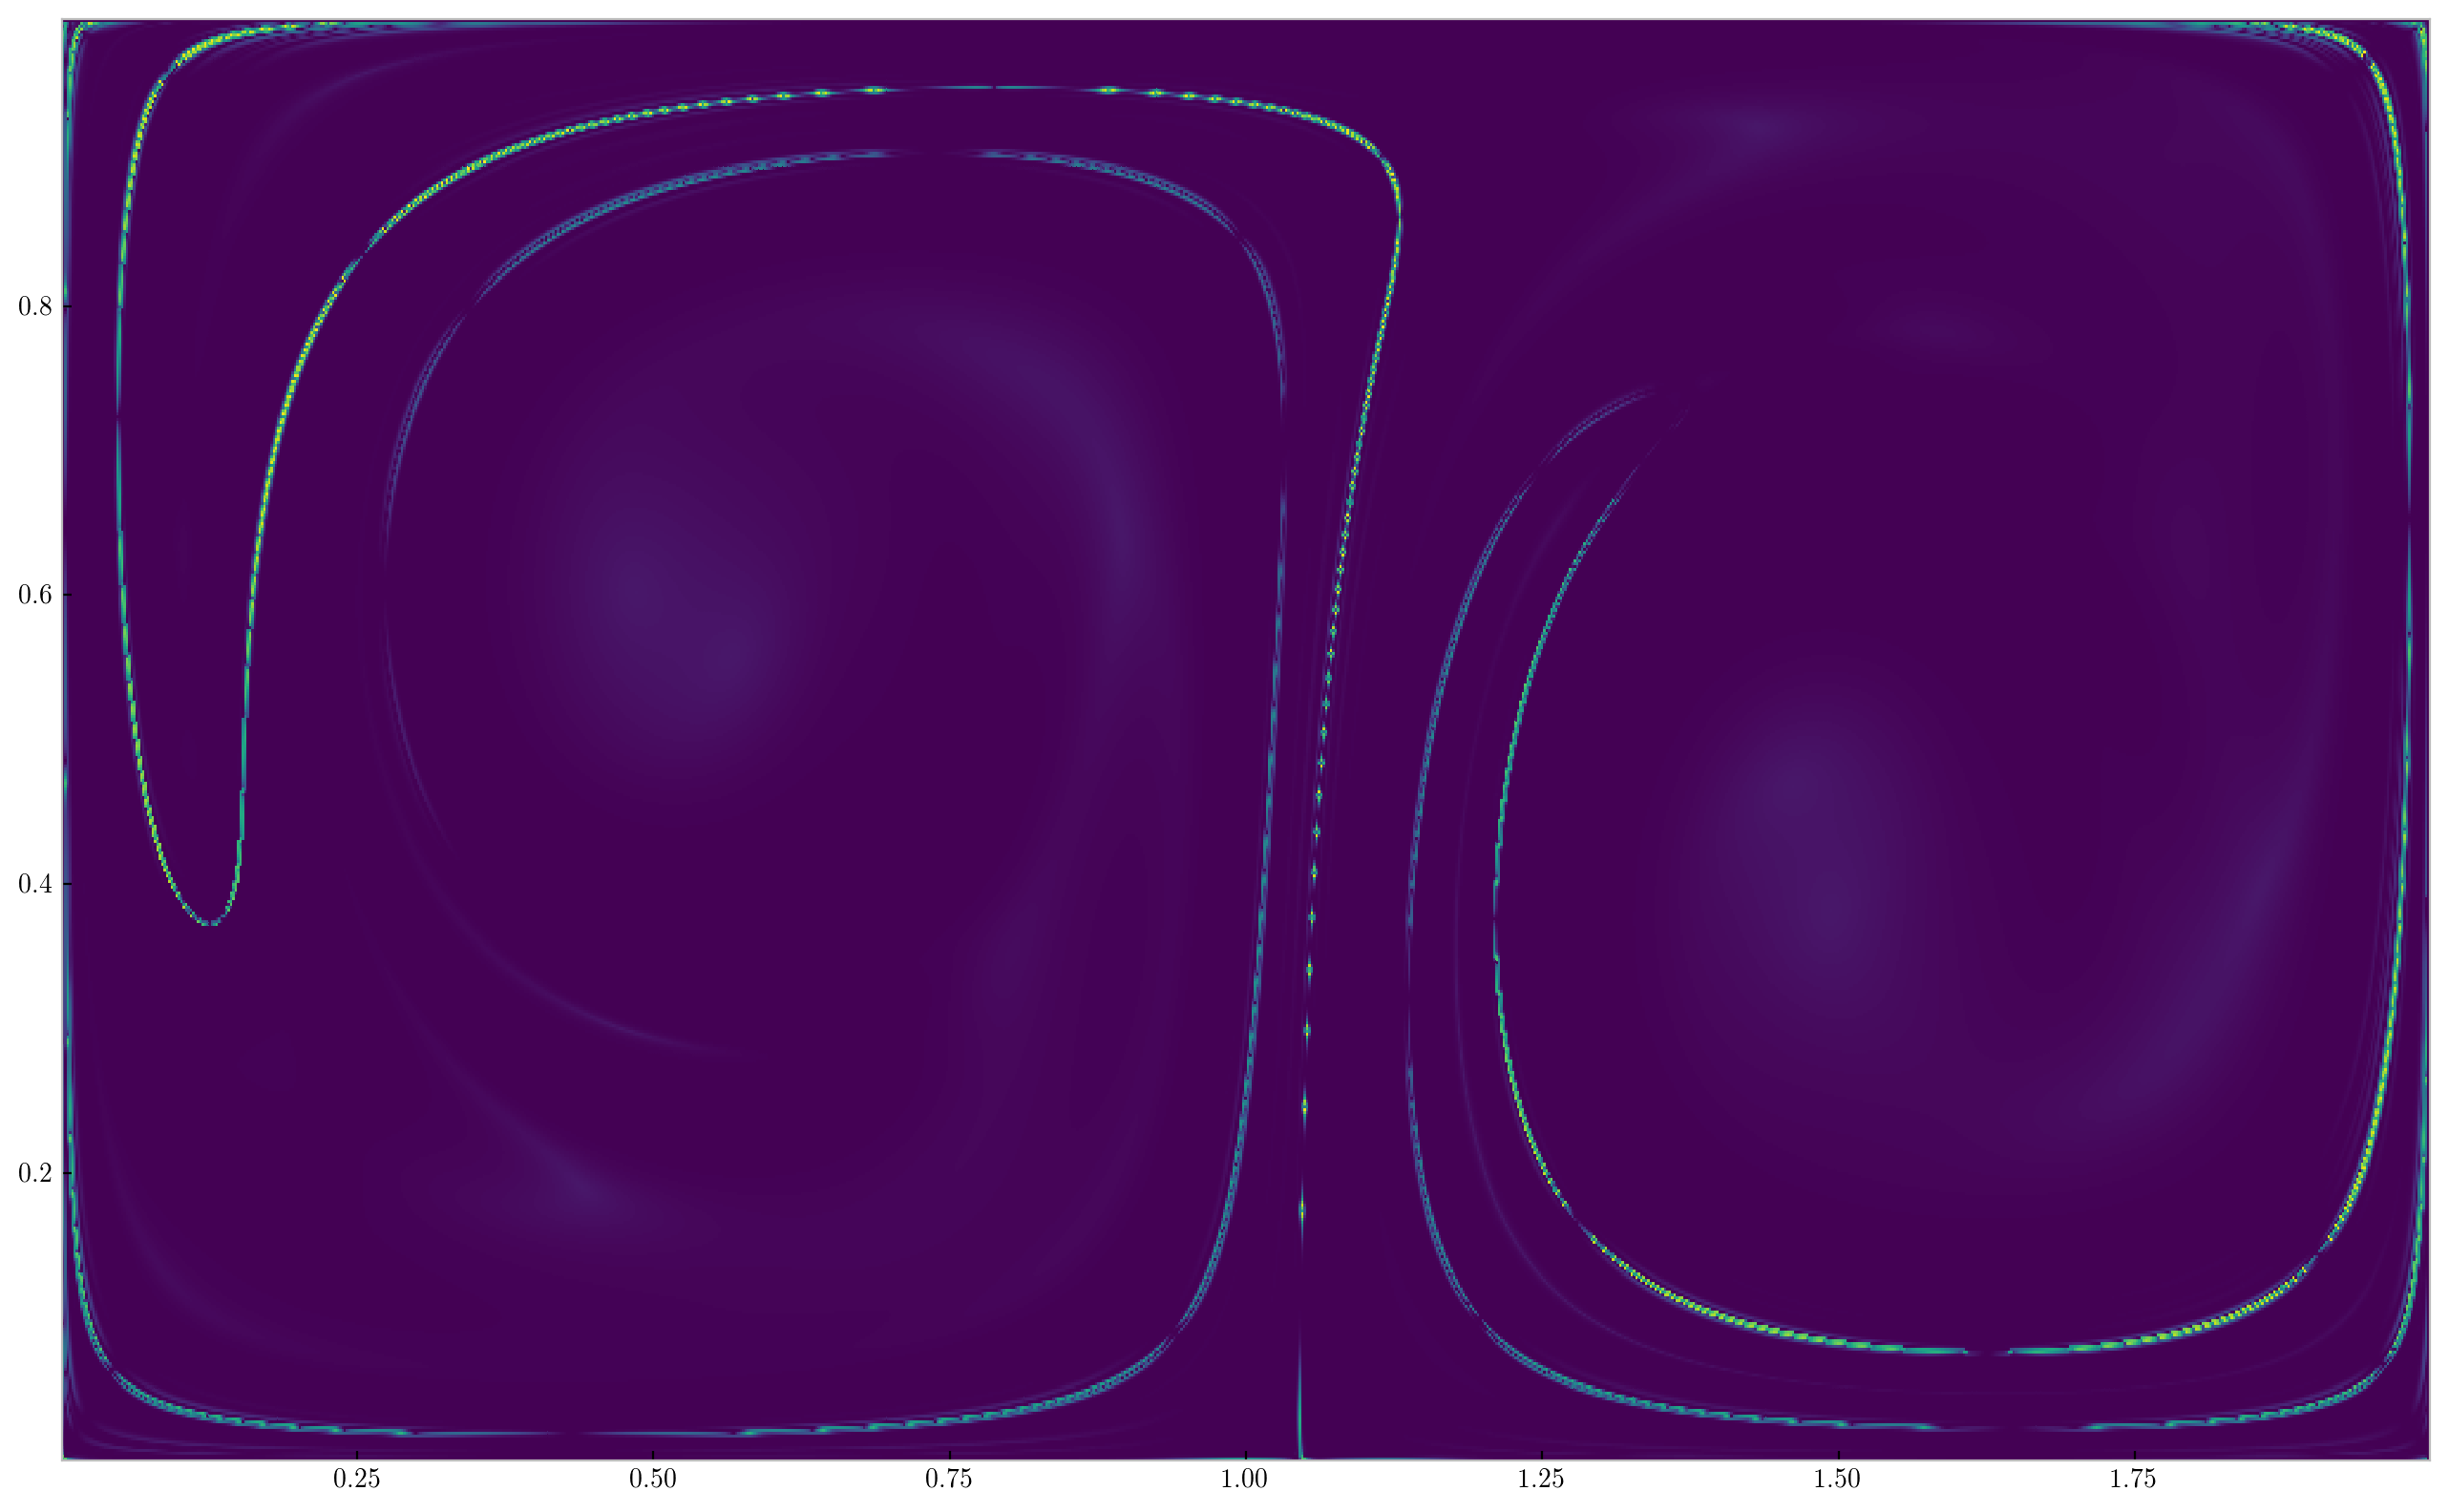

In [133]:
plt.figure(figsize = (16, 10), dpi = 200)
plt.pcolormesh(pos_init[0], pos_init[1], np.log(smallest_eval_spline.ev(pos_init[1], pos_init[0]) + 1) )

In [137]:
np.shape(G_0)

(2, 1357)

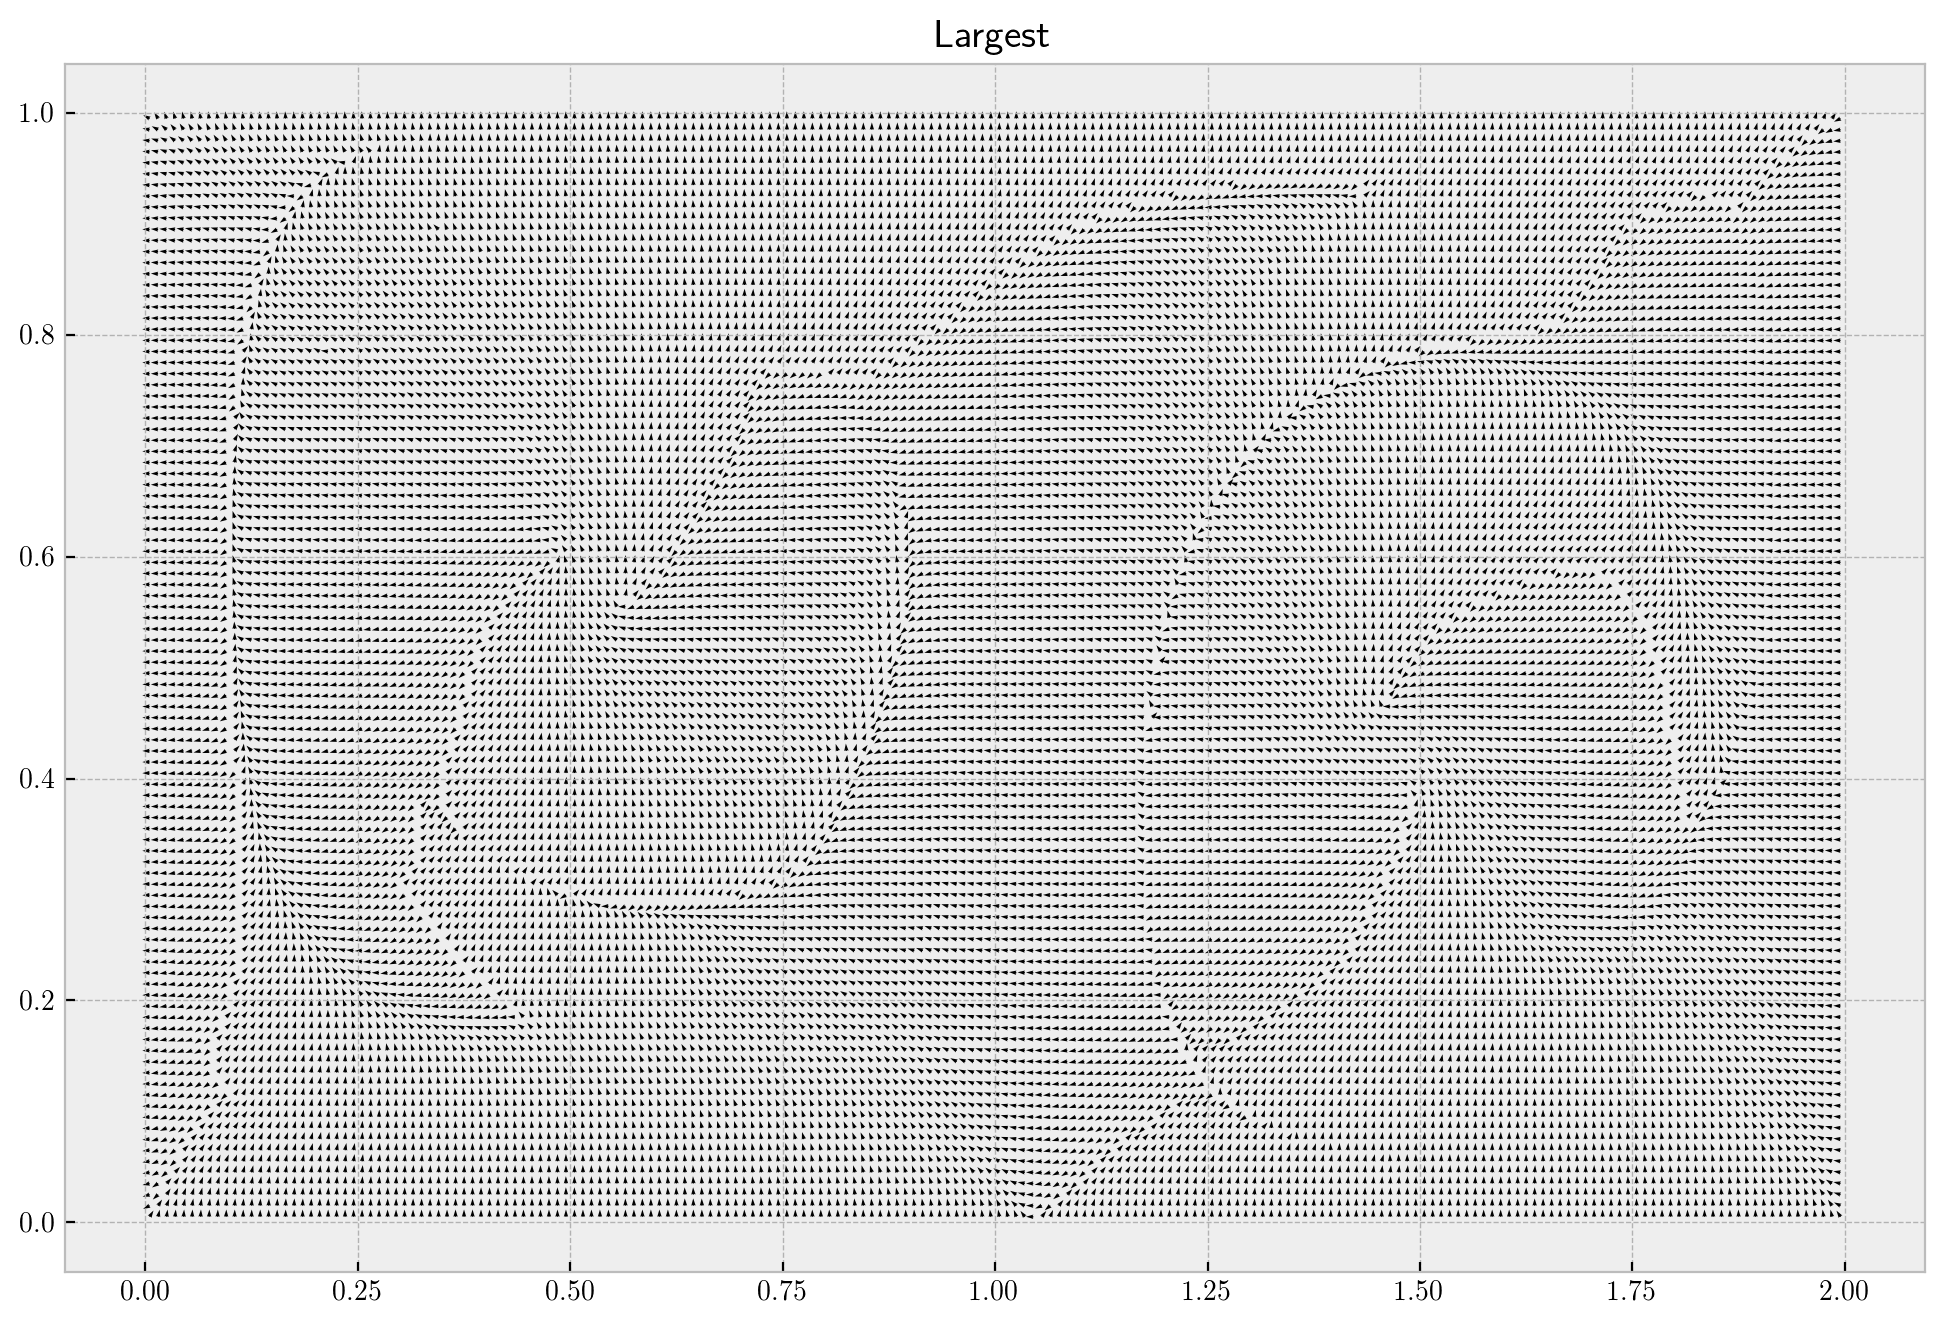

In [17]:
plt.figure(figsize=(12,8), dpi = 200)
plt.quiver(pos_init[0], pos_init[1], evecs[0,0,:,:], evecs[1,0,:,:])
plt.title('Largest')

In [13]:
plt.figure(figsize = (12,8), dpi = 200)
plt.quiver(pos_init[0], pos_init[1], evecs[0,1,:,:], evecs[1,1,:,:])
plt.title('Largest')

NameError: name 'evecs' is not defined